# APWP Analysis

In [1]:
# standard modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.cm import get_cmap
import matplotlib.patches as patches
import os
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy import stats
pd.set_option('display.max_rows',999)
pd.set_option('display.max_columns',999)

# pmagpy
import pmagpy.ipmag as ipmag
import pmagpy.pmag as pmag
import cartopy.crs as ccrs
import cartopy
import xml.etree.ElementTree as ET
import pygplates as pgp

## Functions

In [2]:
def create_vgp_FeatureCollection(compilation):
    """
    Loop through poles and produce a pygplates FeatureCollection of multiple VGPs.
    
    Modified from code by Michael G. Tetley.
    
    Parameters
    ----------
    compilation : dataframe
        pole compilation
        
    Returns
    -------
    vpgFeatureCollection : FeatureCollection
        pygplates FeatureCollection of VGPs in compilation
    """
    poleLat = []
    poleLon = []
    poleName = []
    poleSiteLat = []
    poleSiteLon = []
    poleNominalAge = []
    poleA95 = []
    poleAgeLowerLimit = []
    poleAgeUpperLimit = []
    plateID = []

    count = 0

    for i in range(len(compilation)):

        if np.isfinite(compilation['slat'][i]) and np.isfinite(compilation['slon'][i]) and \
           np.isfinite(compilation['age lower'][i]) and np.isfinite(compilation['age upper'][i]):

            poleLat.append(compilation['plat'][i])
            poleLon.append(compilation['plon'][i])

            poleName.append(compilation['name'][i] + ' (' + compilation['grade'][i] + ')')
            poleSiteLat.append(compilation['slat'][i])
            poleSiteLon.append(compilation['slon'][i])
            poleNominalAge.append(compilation['age'][i])
            poleA95.append(compilation['a95'][i])

            poleAgeLowerLimit.append(compilation['age lower'][i])
            poleAgeUpperLimit.append(compilation['age upper'][i])

            plateID.append(compilation['plateID'][i])

            count = count + 1

        # Print if any of the isfinite tests fail
        else:

            print('Bad data for : {}'.format(compilation['name'][i]))


    # Create new GPlates Feature Collection
    vpgFeatureCollection = pgp.FeatureCollection()

    # Create new GPlates feature 'VirtualGeomagneticPole'.
    # Pole lat, pole lon, pole name, and reconstruction plate ID added within PointOnSphere method.
    # Inc, Dec, A95, Age and Sample site lat/lon values to added within 'other_properties' method.

    for j in range(count):

        vgpFeature = pgp.Feature.create_reconstructable_feature(
                     pgp.FeatureType.create_gpml('VirtualGeomagneticPole'),
                     pgp.PointOnSphere([np.float(poleLat[j]), np.float(poleLon[j])]),
                     name = poleName[j],
                     reconstruction_plate_id = int(plateID[j]),
                     other_properties = [(pgp.PropertyName.create_gpml('poleA95'), pgp.XsDouble(np.float64(poleA95[j]))),
                                         (pgp.PropertyName.create_gpml('averageAge'), pgp.XsDouble(np.float64(poleNominalAge[j]))),
                                         (pgp.PropertyName.create_gpml('averageSampleSitePosition'),
                                          pgp.GmlPoint(pgp.PointOnSphere([np.float(poleSiteLat[j]), 
                                                                          np.float(poleSiteLon[j])])))])

        # Add newly created feature to existing Feature Collection
        vpgFeatureCollection.add(vgpFeature)

    return vpgFeatureCollection

In [3]:
def create_vgp_gpml(vpgFeatureCollection, filename):
    """
    Create a .gpml for a FeatureCollection of VGPs.
    
    Modified from code by Michael G. Tetley.
    
    Parameters
    ----------
    vpgFeatureCollection : FeatureCollection
        pygplates FeatureCollection of VGPs in compilation
        
    filename : string
        path and name for output .gpml
    """
    # Generate GPML output file
    gpmlOutputFile = filename

    # Check for existing output file with same name and remove if found
    if os.path.isfile(filename):
        os.remove(filename)

    # Check to make sure vgpFeatureCollection (feature collection) is not empty before writing to file
    if len(vpgFeatureCollection) != 0:
        outputFeatureCollection = pgp.FeatureCollectionFileFormatRegistry()
        outputFeatureCollection.write(vpgFeatureCollection, filename)

    # Check if new file was created and confirm export
    if os.path.isfile(filename):
        print('Palaeomagnetic pole data successfully exported in GPML format.')

In [4]:
def get_craton_XYs(gpml, plateIDs):
    """
    Get XY coordinates of a plate polygon from a .gpml.
    
    Parameters
    ----------
    gpml : string
        Path to .gpml file.
        
    plateIDs : list
        Of plateIDs.
    """
    # namespace dictionary
    ns = {'gpml':'http://www.gplates.org/gplates',
          'gml':'http://www.opengis.net/gml'}
    
    # initial parse
    tree = ET.parse(gpml)
    root = tree.getroot()
    
    # storage
    Xs = []
    Ys = []
    
    # iterate through featureMembers
    for featureMember in root.findall('gml:featureMember',ns):
        
        # get child
        for child in featureMember:
            slice_ind = child.tag.find('}')
            child_root = 'gpml:' + child.tag[slice_ind+1:]
        
        # check plateID
        plateID_path = child_root + '/gpml:reconstructionPlateId/gpml:ConstantValue/gpml:value'
        feature_plateID = int(featureMember.find(plateID_path,ns).text)
        if feature_plateID in plateIDs:
            
            if featureMember.find(child_root + '/gpml:outlineOf', ns)!=None:
                polygon_root = child_root + '/gpml:outlineOf'
            elif featureMember.find(child_root + '/gpml:boundary', ns)!=None:
                polygon_root = child_root + '/gpml:boundary'
            elif featureMember.find(child_root + '/gpml:unclassifiedGeometry', ns)!=None:
                polygon_root = child_root + '/gpml:unclassifiedGeometry'
            elif featureMember.find(child_root + '/gpml:centerLineOf', ns)!=None:
                polygon_root = child_root + '/gpml:centerLineOf'
            else:
                raise Exception('polygon_root undefined.')
            
            # get coordinates
            posList_path = polygon_root + '/gpml:ConstantValue/gpml:value/gml:Polygon/gml:exterior/gml:LinearRing/gml:posList'
            for feature_posList in featureMember.findall(posList_path,ns):
                np_posList = np.fromstring(feature_posList.text, dtype=float, sep=' ')
            
                # split into lat and lon
                lat_inds = np.arange(0, len(np_posList), 2, dtype=int)
                lon_inds = np.arange(1, len(np_posList), 2, dtype=int)

                feature_lat = np_posList[lat_inds]
                feature_lon = np_posList[lon_inds]
            
                Xs.append(feature_lon)
                Ys.append(feature_lat)
            
    return Xs, Ys

In [5]:
def craton_plot(ax, plateIDs, Eulers, edgecolor, facecolor, alpha, linewidth):
    """
    Plot cratons with rotation.
    
    Parameters
    ----------
    ax : map axis
        On which to plot.
    
    plateIDs : list
        Of plateIDs.
        
    Eulers : list of lists
        Of Euler rotation parameters - if more than one given,
        the rotations will be additive.
    """
    # get cratons from .gpml
    gpml = '../../../Rodinia_Model/Merdith-modified/shapes/shapes_cratons.gpml'
    Xs, Ys = get_craton_XYs(gpml, plateIDs)
    
    # rotate cratons
    rotated_Xs = []
    rotated_Ys = []
    for i in range(len(Xs)):
        rotated_X = np.array([])
        rotated_Y = np.array([])
        for j in range(len(Xs[i])):
            this_X = [Xs[i][j]]
            this_Y = [Ys[i][j]]
            for k in range(len(Eulers)):
                this_Y, this_X = pmag.pt_rot(Eulers[k], this_Y, this_X)
            rotated_X = np.append(rotated_X, this_X)
            rotated_Y = np.append(rotated_Y, this_Y)
        rotated_Xs.append(rotated_X)
        rotated_Ys.append(rotated_Y)
        
    # add cratons
    for i in range(len(rotated_Xs)):
        XY = np.stack([rotated_Xs[i][::-1],rotated_Ys[i][::-1]],axis=1)
        poly_edge = patches.Polygon(XY,
                                    edgecolor=edgecolor,facecolor='none',alpha=alpha,
                                    transform=ccrs.Geodetic(), linewidth=linewidth)
        poly_face = patches.Polygon(XY,
                                    edgecolor='none',facecolor=facecolor,alpha=alpha,
                                    transform=ccrs.Geodetic())
        ax.add_patch(poly_face)
        ax.add_patch(poly_edge)

In [6]:
def equi_filled(map_axis, centerlon, centerlat, radius, color, alpha=1.0):
    """
    Modified from the ipmag function equi().
    """
    glon1 = centerlon
    glat1 = centerlat
    X = []
    Y = []
    for azimuth in range(0, 360):
        glon2, glat2, baz = ipmag.shoot(glon1, glat1, azimuth, radius)
        X.append(glon2)
        Y.append(glat2)
    X.append(X[0])
    Y.append(Y[0])
    
    X = X[::-1]
    Y = Y[::-1]
    
    XY = np.stack([X,Y],axis=1)
    
    circle_edge = patches.Polygon(XY,
                                  edgecolor=color,facecolor='none',
                                  transform=ccrs.Geodetic())
    circle_face = patches.Polygon(XY,
                                  edgecolor='none',facecolor=color,alpha=alpha,
                                  transform=ccrs.Geodetic())
    
    map_axis.add_patch(circle_face)
    map_axis.add_patch(circle_edge)

In [7]:
def rotated_pole_plot(ax, plon, plat, a95, Eulers, marker, s, marker_color, a95_color, a95_alpha):
    """
    Plot paleomagnetic pole with rotation.
    """
    # rotate pole
    rotated_plat = plat
    rotated_plon = plon
    for i in range(len(Eulers)):
        rotated_plat, rotated_plon = pmag.pt_rot(Eulers[i], [rotated_plat], [rotated_plon])
        rotated_plat = rotated_plat[0]
        rotated_plon = rotated_plon[0]
    
    # degrees to km conversion
    a95_km = a95 * 111.32
    
    # pole
    ax.scatter(rotated_plon, rotated_plat, marker=marker,
               color=marker_color, edgecolors='k', s=s,
               label='__nolegend__', zorder=101, transform=ccrs.PlateCarree())
    
    # a95
    equi_filled(ax, rotated_plon, rotated_plat, a95_km, a95_color, alpha=a95_alpha)

In [8]:
def APWP_plot(ax,
              plon_rot, plat_rot, a95_rot, age_rot,
              plon_fix, plat_fix, a95_fix, age_fix,
              Euler,
              label_rot, color_rot, marker_rot, s_rot,
              label_fix, color_fix, marker_fix, s_fix,
              age_lim=None, cmap='viridis'):
    """
    Plot apparent polar wander paths for two connected cratons.
    """
    # get vmin and vmax, and slice data if necessary
    if age_lim==None:
        vmin = np.min([age_rot.min(), age_fix.min()])
        vmax = np.max([age_rot.max(), age_fix.max()])
    else:
        vmin = age_lim[0]
        vmax = age_lim[1]
        
        rot_mask = (age_rot>=age_lim[0])&(age_rot<=age_lim[1])
        plon_rot = plon_rot[rot_mask]
        plat_rot = plat_rot[rot_mask]
        a95_rot = a95_rot[rot_mask]
        age_rot = age_rot[rot_mask]
        
        fix_mask = (age_fix>=age_lim[0])&(age_fix<=age_lim[1])
        plon_fix = plon_fix[fix_mask]
        plat_fix = plat_fix[fix_mask]
        a95_fix = a95_fix[fix_mask]
        age_fix = age_fix[fix_mask]
    
    # rotate poles
    rotated_plat = np.array([])
    rotated_plon = np.array([])
    
    for i in range(len(plon_rot)):
        this_plat, this_plon = pmag.pt_rot(Euler, [plat_rot[i]], [plon_rot[i]])
        rotated_plat = np.append(rotated_plat, this_plat[0])
        rotated_plon = np.append(rotated_plon, this_plon[0])
    
    # degrees to km conversion
    a95_rot_km = a95_rot * 111.32
    a95_fix_km = a95_fix * 111.32
    
    # colormap to age
    color_mapping = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    colors_rot = color_mapping.to_rgba(age_rot).tolist()
    colors_fix = color_mapping.to_rgba(age_fix).tolist()
    
    # pole
    ax.scatter(plon_fix, plat_fix, marker=marker_fix,
               color=colors_fix, edgecolors='k', s=s_fix,
               label='__nolegend__', zorder=101, transform=ccrs.Geodetic())
    ax.scatter(rotated_plon, rotated_plat, marker=marker_rot,
               color=colors_rot, edgecolors='k', s=s_rot,
               label='__nolegend__', zorder=101, transform=ccrs.Geodetic())
    
    # a95
    for i in range(len(plon_fix)):
        equi_filled(ax, plon_fix[i], plat_fix[i], a95_fix_km[i], color_fix, alpha=0.3)
    for i in range(len(rotated_plon)):
        equi_filled(ax, rotated_plon[i], rotated_plat[i], a95_rot_km[i], color_rot, alpha=0.3)
        
    # create fake legend
    ax.scatter([], [], marker=marker_fix,
               color=color_fix, edgecolors='k', s=s_fix,
               label=label_fix, transform=ccrs.Geodetic())
    ax.scatter([], [], marker=marker_rot,
               color=color_rot, edgecolors='k', s=s_rot,
               label=label_rot, transform=ccrs.Geodetic())
    
    # colorbar
    color_mapping._A = []
    plt.colorbar(color_mapping, orientation='horizontal', shrink=0.8,
                 pad=0.05, label='age [Ma]')
    
    # prettify
    ax.legend(loc=4, fontsize=12)
    ax.set_title('{} rotated to {} - Euler : {}'.format(label_rot,label_fix,str(Euler)))
    
    plt.show()

In [9]:
SChina_color = '#2ecc71'
Laurentia_color = '#1e5b8d'
Svalbard_color = '#8ab6d4'
Australia_color = '#e74c3c'
India_color = '#f5c10e'
Rayner_color = '#ffe27e'
Siberia_color = '#3498db'
Antarctica_color = '#ff9f96'

## South China Poles

In [10]:
compilation_cols = ['name',
                    'terrane',
                    'age',
                    'age upper',
                    'age lower',
                    'plat',
                    'plon',
                    'a95',
                    'f',
                    'slat',
                    'slon',
                    'dec',
                    'inc',
                    'dir_a95',
                    'pole ref',
                    'age ref',
                    'grade',
                    'note',
                    'plateID']

In [11]:
SChina = pd.DataFrame(columns=compilation_cols)
i = 0

### Banxi Group

* These poles are developed in `Banxi_site_analysis.ipynb`.

In [12]:
SChina.loc[i, 'name']    = 'Banxi Group - site mean (f=1.0)'
SChina.loc[i, 'terrane'] = 'SChina'
SChina.loc[i, 'age']       = 814
SChina.loc[i, 'age upper'] = 814 + 1
SChina.loc[i, 'age lower'] = 814 - 1
SChina.loc[i, 'plat'] = 51.7
SChina.loc[i, 'plon'] = 99.9
SChina.loc[i, 'a95']  = np.sqrt(12.0*12.9)
SChina.loc[i, 'f'] = 1.0
SChina.loc[i, 'slat'] = 27.91
SChina.loc[i, 'slon'] = 108.82
SChina.loc[i, 'dec']     = 346.7
SChina.loc[i, 'inc']     = 77.0
SChina.loc[i, 'dir_a95'] = 6.9
SChina.loc[i, 'pole ref'] = 'this study'
SChina.loc[i, 'age ref']  = 'this study'
SChina.loc[i, 'grade'] = 'NR'
SChina.loc[i, 'note']  = '-'
SChina.loc[i, 'plateID'] = 602
i = i + 1

In [13]:
SChina.loc[i, 'name']    = 'Banxi Group - site mean (f=0.6)'
SChina.loc[i, 'terrane'] = 'SChina'
SChina.loc[i, 'age']       = 814
SChina.loc[i, 'age upper'] = 814 + 1
SChina.loc[i, 'age lower'] = 814 - 1
SChina.loc[i, 'plat'] = 43.0
SChina.loc[i, 'plon'] = 104.0
SChina.loc[i, 'a95']  = np.sqrt(8.1*8.3)
SChina.loc[i, 'f'] = 0.6
SChina.loc[i, 'slat'] = 27.91
SChina.loc[i, 'slon'] = 108.82
SChina.loc[i, 'dec']     = 346.8
SChina.loc[i, 'inc']     = 82.0
SChina.loc[i, 'dir_a95'] = 4.3
SChina.loc[i, 'pole ref'] = 'this study'
SChina.loc[i, 'age ref']  = 'this study'
SChina.loc[i, 'grade'] = 'NR'
SChina.loc[i, 'note']  = '-'
SChina.loc[i, 'plateID'] = 602
i = i + 1

In [14]:
SChina.loc[i, 'name']    = 'Banxi Group - specimen mean (f=1.0)'
SChina.loc[i, 'terrane'] = 'SChina'
SChina.loc[i, 'age']       = 814
SChina.loc[i, 'age upper'] = 814 + 1
SChina.loc[i, 'age lower'] = 814 - 1
SChina.loc[i, 'plat'] = 53.0
SChina.loc[i, 'plon'] = 107.6
SChina.loc[i, 'a95']  = np.sqrt(7.4*7.9)
SChina.loc[i, 'f'] = 1.0
SChina.loc[i, 'slat'] = 27.91
SChina.loc[i, 'slon'] = 108.82
SChina.loc[i, 'dec']     = 358.3
SChina.loc[i, 'inc']     = 76.8
SChina.loc[i, 'dir_a95'] = 4.3
SChina.loc[i, 'pole ref'] = 'this study'
SChina.loc[i, 'age ref']  = 'this study'
SChina.loc[i, 'grade'] = 'NR'
SChina.loc[i, 'note']  = '-'
SChina.loc[i, 'plateID'] = 602
i = i + 1

In [15]:
SChina.loc[i, 'name']    = 'Banxi Group - specimen mean (f=0.6)'
SChina.loc[i, 'terrane'] = 'SChina'
SChina.loc[i, 'age']       = 814
SChina.loc[i, 'age upper'] = 814 + 1
SChina.loc[i, 'age lower'] = 814 - 1
SChina.loc[i, 'plat'] = 44.6
SChina.loc[i, 'plon'] = 108.5
SChina.loc[i, 'a95']  = np.sqrt(5.3*5.5)
SChina.loc[i, 'f'] = 0.6
SChina.loc[i, 'slat'] = 27.91
SChina.loc[i, 'slon'] = 108.82
SChina.loc[i, 'dec']     = 359.2
SChina.loc[i, 'inc']     = 81.5
SChina.loc[i, 'dir_a95'] = 2.8
SChina.loc[i, 'pole ref'] = 'this study'
SChina.loc[i, 'age ref']  = 'this study'
SChina.loc[i, 'grade'] = 'NR'
SChina.loc[i, 'note']  = '-'
SChina.loc[i, 'plateID'] = 602
i = i + 1

In [16]:
SChina.loc[i, 'name']    = 'Banxi Group - Luoman specimen mean (f=0.6)'
SChina.loc[i, 'terrane'] = 'SChina'
SChina.loc[i, 'age']       = 814
SChina.loc[i, 'age upper'] = 814 + 1
SChina.loc[i, 'age lower'] = 814 - 1
SChina.loc[i, 'plat'] = 40.2
SChina.loc[i, 'plon'] = 111.2
SChina.loc[i, 'a95']  = np.sqrt(8.5*8.6)
SChina.loc[i, 'f'] = 0.6
SChina.loc[i, 'slat'] = 27.91
SChina.loc[i, 'slon'] = 108.82
SChina.loc[i, 'dec']     = 8.5
SChina.loc[i, 'inc']     = 83.7
SChina.loc[i, 'dir_a95'] = 4.4
SChina.loc[i, 'pole ref'] = 'this study'
SChina.loc[i, 'age ref']  = 'this study'
SChina.loc[i, 'grade'] = 'NR'
SChina.loc[i, 'note']  = '-'
SChina.loc[i, 'plateID'] = 602
i = i + 1

In [17]:
SChina.loc[i, 'name']    = 'Banxi Group - Mamaguo specimen mean (f=0.6)'
SChina.loc[i, 'terrane'] = 'SChina'
SChina.loc[i, 'age']       = 814
SChina.loc[i, 'age upper'] = 814 + 1
SChina.loc[i, 'age lower'] = 814 - 1
SChina.loc[i, 'plat'] = 42.1
SChina.loc[i, 'plon'] = 92.7
SChina.loc[i, 'a95']  = np.sqrt(8.2*8.5)
SChina.loc[i, 'f'] = 0.6
SChina.loc[i, 'slat'] = 27.91
SChina.loc[i, 'slon'] = 108.82
SChina.loc[i, 'dec']     = 321.5
SChina.loc[i, 'inc']     = 80.0
SChina.loc[i, 'dir_a95'] = 4.5
SChina.loc[i, 'pole ref'] = 'this study'
SChina.loc[i, 'age ref']  = 'this study'
SChina.loc[i, 'grade'] = 'NR'
SChina.loc[i, 'note']  = '-'
SChina.loc[i, 'plateID'] = 602
i = i + 1

### Yanbian Dikes

* A 5 degree vertical axis rotation is applied to these data in the paper. They are not tilt-corrected (except for one) although they are located within a mobile belt.
* Baked contact test, dike-tilt test, rock magnetism.
* SIMS on dike.

In [18]:
SChina.loc[i, 'name']    = 'Yanbian Dikes Group A'
SChina.loc[i, 'terrane'] = 'SChina'
SChina.loc[i, 'age']       = 824
SChina.loc[i, 'age upper'] = 824 + 6
SChina.loc[i, 'age lower'] = 824 - 6
SChina.loc[i, 'plat'] = 45.1
SChina.loc[i, 'plon'] = 130.4
SChina.loc[i, 'a95']  = 19.0
SChina.loc[i, 'f'] = 1.0
SChina.loc[i, 'slat'] = 26.886
SChina.loc[i, 'slon'] = 101.546
SChina.loc[i, 'dec']     = np.nan
SChina.loc[i, 'inc']     = np.nan
SChina.loc[i, 'dir_a95'] = np.nan
SChina.loc[i, 'pole ref'] = 'Niu et al. (2016)'
SChina.loc[i, 'age ref']  = 'Niu et al. (2016)'
SChina.loc[i, 'grade'] = 'B'
SChina.loc[i, 'note']  = '-'
SChina.loc[i, 'plateID'] = 602
i = i + 1

### Xiaofeng Dikes

* Age from TIMS on tuffs.
* Reversal test, regional geology.
* Pole recalculated in Jing et al. (2019)
* Specimen level data not available with publication.

In [19]:
SChina.loc[i, 'name']    = 'Xiaofeng Dikes - Li et al. (2004)'
SChina.loc[i, 'terrane'] = 'SChina'
SChina.loc[i, 'age']       = 821
SChina.loc[i, 'age upper'] = 821.64 + 0.2
SChina.loc[i, 'age lower'] = 821.10 - 0.2
SChina.loc[i, 'plat'] = 13.5
SChina.loc[i, 'plon'] = 91.0
SChina.loc[i, 'a95']  = np.sqrt(10.5*11.3)
SChina.loc[i, 'f'] = 1.0
SChina.loc[i, 'slat'] = 30.96
SChina.loc[i, 'slon'] = 111.23
SChina.loc[i, 'dec']     = 51.3+180
SChina.loc[i, 'inc']     = -(-76.6)
SChina.loc[i, 'dir_a95'] = 6.1
SChina.loc[i, 'pole ref'] = 'Li et al. (2004)'
SChina.loc[i, 'age ref']  = 'Wang et al. (2016)'
SChina.loc[i, 'grade'] = 'B'
SChina.loc[i, 'note']  = '-'
SChina.loc[i, 'plateID'] = 602
i = i + 1

SChina.loc[i, 'name']    = 'Xiaofeng Dikes - Jing et al. (2019)'
SChina.loc[i, 'terrane'] = 'SChina'
SChina.loc[i, 'age']       = 821
SChina.loc[i, 'age upper'] = 821.64 + 0.2
SChina.loc[i, 'age lower'] = 821.10 - 0.2
SChina.loc[i, 'plat'] = 26.1
SChina.loc[i, 'plon'] = 82.1
SChina.loc[i, 'a95']  = np.sqrt(14.0*15.2)
SChina.loc[i, 'f'] = 1.0
SChina.loc[i, 'slat'] = 30.96
SChina.loc[i, 'slon'] = 111.23
SChina.loc[i, 'dec']     = 86.5+180
SChina.loc[i, 'inc']     = -(-76.3)
SChina.loc[i, 'dir_a95'] = 8.2
SChina.loc[i, 'pole ref'] = 'Jing et al. (2019)'
SChina.loc[i, 'age ref']  = 'Wang et al. (2016)'
SChina.loc[i, 'grade'] = 'B'
SChina.loc[i, 'note']  = '-'
SChina.loc[i, 'plateID'] = 602
i = i + 1

### Madiyi Formation

* Inclination correction preferred by authors.
* Reversal test.
* SIMS on tuff.
* Age updated with CA-ID-TIMS in this study.

Specimen mean, as reported in Xian et al. (2020):

In [20]:
SChina.loc[i, 'name']    = 'Madiyi Formation - specimen mean (f=1.0)'
SChina.loc[i, 'terrane'] = 'SChina'
SChina.loc[i, 'age']       = 804.9
SChina.loc[i, 'age upper'] = 804.9 + 0.36
SChina.loc[i, 'age lower'] = 804.9 - 0.36
SChina.loc[i, 'plat'] = 35.3
SChina.loc[i, 'plon'] = 67.9
SChina.loc[i, 'a95']  = np.sqrt(4.7*5.5)
SChina.loc[i, 'f'] = 1.0
SChina.loc[i, 'slat'] = 27.5
SChina.loc[i, 'slon'] = 109.6
SChina.loc[i, 'dec']     = 293.1
SChina.loc[i, 'inc']     = 69.9
SChina.loc[i, 'dir_a95'] = 3.2
SChina.loc[i, 'pole ref'] = 'Xian et al. (2020)'
SChina.loc[i, 'age ref']  = 'this study'
SChina.loc[i, 'grade'] = 'NR'
SChina.loc[i, 'note']  = '-'
SChina.loc[i, 'plateID'] = 602
i = i + 1

In [21]:
SChina.loc[i, 'name']    = 'Madiyi Formation - specimen mean (f=0.6)'
SChina.loc[i, 'terrane'] = 'SChina'
SChina.loc[i, 'age']       = 804.9
SChina.loc[i, 'age upper'] = 804.9 + 0.36
SChina.loc[i, 'age lower'] = 804.9 - 0.36
SChina.loc[i, 'plat'] = 34.3
SChina.loc[i, 'plon'] = 82.4
SChina.loc[i, 'a95']  = np.sqrt(3.9*3.7)
SChina.loc[i, 'f'] = 0.6
SChina.loc[i, 'slat'] = 27.5
SChina.loc[i, 'slon'] = 109.6
SChina.loc[i, 'dec']     = 293.0
SChina.loc[i, 'inc']     = 77.3
SChina.loc[i, 'dir_a95'] = 2.1
SChina.loc[i, 'pole ref'] = 'Xian et al. (2020)'
SChina.loc[i, 'age ref']  = 'this study'
SChina.loc[i, 'grade'] = 'NR'
SChina.loc[i, 'note']  = '-'
SChina.loc[i, 'plateID'] = 602
i = i + 1

Calculate our own site mean version of the pole:

In [22]:
Xian2020 = pd.read_csv('../Data/Xian2020a.csv')
Xian2020.columns

Index(['site', 'n', 'dec_geog', 'inc_geog', 'dec', 'inc', 'k', 'a95', 'plat',
       'plon', 'dp', 'dm', 'polarity'],
      dtype='object')

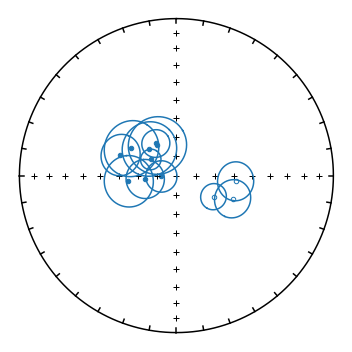

In [23]:
fignum = 1
plt.figure(num=fignum,figsize=(5,5))
ipmag.plot_net(fignum)
for j in range(len(Xian2020)):
    ipmag.plot_di_mean(Xian2020['dec'][j], Xian2020['inc'][j], Xian2020['a95'][j], color='C0')
plt.show()

Dec: 293.7  Inc: 69.0
Number of directions in mean (n): 12
Angular radius of 95% confidence (a_95): 5.8
Precision parameter (k) estimate: 56.5


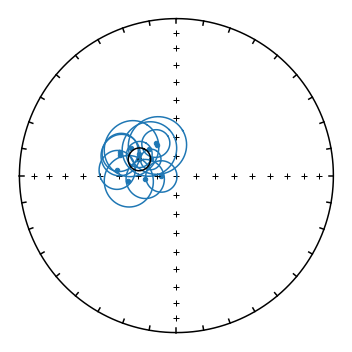

In [24]:
Xian2020_inc_flipped = []
Xian2020_dec_flipped = []
Xian2020_a95_flipped = []

for j in range(len(Xian2020)):
    if Xian2020['inc'][j] < 0:
        Xian2020_inc_flipped.append(-Xian2020['inc'][j])
        Xian2020_dec_flipped.append(Xian2020['dec'][j]+180)
    else:
        Xian2020_inc_flipped.append(Xian2020['inc'][j])
        Xian2020_dec_flipped.append(Xian2020['dec'][j])
    Xian2020_a95_flipped.append(Xian2020['a95'][j])

Xian2020_site_mean_10 = ipmag.fisher_mean(Xian2020_dec_flipped,Xian2020_inc_flipped)

ipmag.print_direction_mean(Xian2020_site_mean_10)

fignum = 1
plt.figure(num=fignum,figsize=(5,5))
ipmag.plot_net(fignum)
for j in range(len(Xian2020)):
    ipmag.plot_di_mean(Xian2020_dec_flipped[j], Xian2020_inc_flipped[j], Xian2020_a95_flipped[j], color='C0')
ipmag.plot_di_mean(Xian2020_site_mean_10['dec'],
                   Xian2020_site_mean_10['inc'],
                   Xian2020_site_mean_10['alpha95'],
                   color='k')
plt.show()

In [25]:
print('site mean VGP, f = 1.0 - (lon, lat, dp, dm)')
Madiyi_site_10_vgp = pmag.dia_vgp(Xian2020_site_mean_10['dec'],
                                  Xian2020_site_mean_10['inc'],
                                  Xian2020_site_mean_10['alpha95'],
                                  27.5,109.6)
Madiyi_site_10_vgp

site mean VGP, f = 1.0 - (lon, lat, dp, dm)


(66.23702125862057, 35.707893358138506, 8.408037964380522, 9.89658126030523)

In [26]:
SChina.loc[i, 'name']    = 'Madiyi Formation - site mean (f=1.0)'
SChina.loc[i, 'terrane'] = 'SChina'
SChina.loc[i, 'age']       = 804.9
SChina.loc[i, 'age upper'] = 804.9 + 0.36
SChina.loc[i, 'age lower'] = 804.9 - 0.36
SChina.loc[i, 'plat'] = Madiyi_site_10_vgp[1]
SChina.loc[i, 'plon'] = Madiyi_site_10_vgp[0]
SChina.loc[i, 'a95']  = np.sqrt(Madiyi_site_10_vgp[2]*Madiyi_site_10_vgp[3])
SChina.loc[i, 'f'] = 1.0
SChina.loc[i, 'slat'] = 27.5
SChina.loc[i, 'slon'] = 109.6
SChina.loc[i, 'dec']     = Xian2020_site_mean_10['dec']
SChina.loc[i, 'inc']     = Xian2020_site_mean_10['inc']
SChina.loc[i, 'dir_a95'] = Xian2020_site_mean_10['alpha95']
SChina.loc[i, 'pole ref'] = 'Xian et al. (2020)'
SChina.loc[i, 'age ref']  = 'this study'
SChina.loc[i, 'grade'] = 'NR'
SChina.loc[i, 'note']  = '-'
SChina.loc[i, 'plateID'] = 602
i = i + 1

Apply a per-site inclination correction:

Dec: 293.6  Inc: 76.9
Number of directions in mean (n): 12
Angular radius of 95% confidence (a_95): 3.7
Precision parameter (k) estimate: 135.5


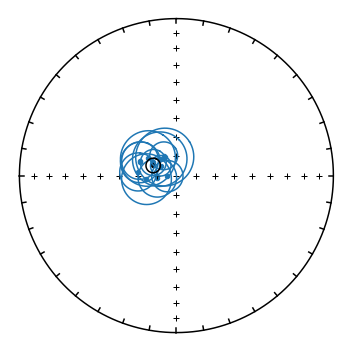

In [27]:
Xian2020_inc_flipped_ic = ipmag.unsquish(Xian2020_inc_flipped, 0.6)

Xian2020_site_mean_06 = ipmag.fisher_mean(Xian2020_dec_flipped,Xian2020_inc_flipped_ic)

ipmag.print_direction_mean(Xian2020_site_mean_06)

fignum = 1
plt.figure(num=fignum,figsize=(5,5))
ipmag.plot_net(fignum)
for j in range(len(Xian2020)):
    ipmag.plot_di_mean(Xian2020_dec_flipped[j], Xian2020_inc_flipped_ic[j], Xian2020_a95_flipped[j], color='C0')
ipmag.plot_di_mean(Xian2020_site_mean_06['dec'],
                   Xian2020_site_mean_06['inc'],
                   Xian2020_site_mean_06['alpha95'],
                   color='k')
plt.show()

In [28]:
print('site mean VGP, f = 0.6 - (lon, lat, dp, dm)')
Madiyi_site_06_vgp = pmag.dia_vgp(Xian2020_site_mean_06['dec'],
                                  Xian2020_site_mean_06['inc'],
                                  Xian2020_site_mean_06['alpha95'],
                                  27.5,109.6)
Madiyi_site_06_vgp

site mean VGP, f = 0.6 - (lon, lat, dp, dm)


(81.52920387112, 34.63619151604563, 6.4819258816260925, 6.964679231756815)

In [29]:
SChina.loc[i, 'name']    = 'Madiyi Formation - site mean (f=0.6)'
SChina.loc[i, 'terrane'] = 'SChina'
SChina.loc[i, 'age']       = 804.9
SChina.loc[i, 'age upper'] = 804.9 + 0.36
SChina.loc[i, 'age lower'] = 804.9 - 0.36
SChina.loc[i, 'plat'] = Madiyi_site_06_vgp[1]
SChina.loc[i, 'plon'] = Madiyi_site_06_vgp[0]
SChina.loc[i, 'a95']  = np.sqrt(Madiyi_site_06_vgp[2]*Madiyi_site_06_vgp[3])
SChina.loc[i, 'f'] = 0.6
SChina.loc[i, 'slat'] = 27.5
SChina.loc[i, 'slon'] = 109.6
SChina.loc[i, 'dec']     = Xian2020_site_mean_06['dec']
SChina.loc[i, 'inc']     = Xian2020_site_mean_06['inc']
SChina.loc[i, 'dir_a95'] = Xian2020_site_mean_06['alpha95']
SChina.loc[i, 'pole ref'] = 'Xian et al. (2020)'
SChina.loc[i, 'age ref']  = 'this study'
SChina.loc[i, 'grade'] = 'NR'
SChina.loc[i, 'note']  = '-'
SChina.loc[i, 'plateID'] = 602
i = i + 1

### Chengjiang Formation

* Fold test, reversal test.
* SIMS on tuffaceous siltstone.

In [30]:
Chengjiang_sample_dec = 111.9+180
Chengjiang_sample_inc = -(-66.7)
Chengjiang_sample_a95 = 5.2
Chengjiang_sample_slat = 25.145
Chengjiang_sample_slon = 102.411

SChina.loc[i, 'name']    = 'Chengjiang Formation - specimen mean (f=1.0)'
SChina.loc[i, 'terrane'] = 'SChina'
SChina.loc[i, 'age']       = 799.5
SChina.loc[i, 'age upper'] = 799.5 + 8.4
SChina.loc[i, 'age lower'] = 799.5 - 8.4
SChina.loc[i, 'plat'] = 33.4
SChina.loc[i, 'plon'] = 56.1
SChina.loc[i, 'a95']  = np.sqrt(7.3*8.9)
SChina.loc[i, 'f'] = 1.0
SChina.loc[i, 'slat'] = Chengjiang_sample_slat
SChina.loc[i, 'slon'] = Chengjiang_sample_slon
SChina.loc[i, 'dec']     = Chengjiang_sample_dec
SChina.loc[i, 'inc']     = Chengjiang_sample_inc
SChina.loc[i, 'dir_a95'] = Chengjiang_sample_a95
SChina.loc[i, 'pole ref'] = 'Jing et al. (2019)'
SChina.loc[i, 'age ref']  = 'Jing et al. (2019)'
SChina.loc[i, 'grade'] = 'NR'
SChina.loc[i, 'note']  = '-'
SChina.loc[i, 'plateID'] = 602
i = i + 1

Do an inclination correction:

In [31]:
Chengjiang_sample_inc_unsquished = ipmag.unsquish([Chengjiang_sample_inc],0.6)[0]

Chengjiang_sample_vgp_unsquished = pmag.dia_vgp(Chengjiang_sample_dec,
                                                Chengjiang_sample_inc_unsquished,
                                                Chengjiang_sample_a95,
                                                Chengjiang_sample_slat,
                                                Chengjiang_sample_slon)

SChina.loc[i, 'name']    = 'Chengjiang Formation - specimen mean (f=0.6)'
SChina.loc[i, 'terrane'] = 'SChina'
SChina.loc[i, 'age']       = 799.5
SChina.loc[i, 'age upper'] = 799.5 + 8.4
SChina.loc[i, 'age lower'] = 799.5 - 8.4
SChina.loc[i, 'plat'] = Chengjiang_sample_vgp_unsquished[1]
SChina.loc[i, 'plon'] = Chengjiang_sample_vgp_unsquished[0]
SChina.loc[i, 'a95']  = np.sqrt(Chengjiang_sample_vgp_unsquished[2]*Chengjiang_sample_vgp_unsquished[3])
SChina.loc[i, 'f'] = 0.6
SChina.loc[i, 'slat'] = Chengjiang_sample_slat
SChina.loc[i, 'slon'] = Chengjiang_sample_slon
SChina.loc[i, 'dec']     = Chengjiang_sample_dec
SChina.loc[i, 'inc']     = Chengjiang_sample_inc_unsquished
SChina.loc[i, 'dir_a95'] = Chengjiang_sample_a95
SChina.loc[i, 'pole ref'] = 'Jing et al. (2019)'
SChina.loc[i, 'age ref']  = 'Jing et al. (2019)'
SChina.loc[i, 'grade'] = 'NR'
SChina.loc[i, 'note']  = 'Inclination correction calculated on mean direction only.'
SChina.loc[i, 'plateID'] = 602
i = i + 1

Calculate our own site mean version of the pole:

In [32]:
Jing2019 = pd.read_csv('../Data/Jing2019a.csv')
Jing2019.columns

Index(['site', 'component', 'n', 'dec_geog', 'inc_geog', 'dec', 'inc', 'k',
       'a95', 'methods'],
      dtype='object')

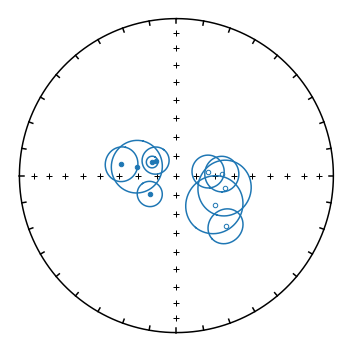

In [33]:
fignum = 1
plt.figure(num=fignum,figsize=(5,5))
ipmag.plot_net(fignum)
for j in range(len(Jing2019)):
    ipmag.plot_di_mean(Jing2019['dec'][j], Jing2019['inc'][j], Jing2019['a95'][j], color='C0')
plt.show()

Dec: 287.0  Inc: 69.2
Number of directions in mean (n): 10
Angular radius of 95% confidence (a_95): 6.9
Precision parameter (k) estimate: 50.2


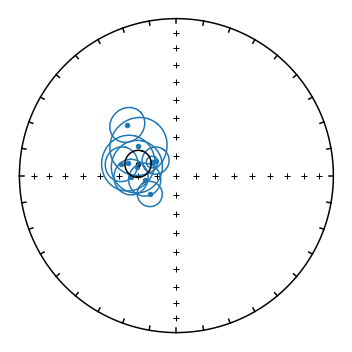

In [34]:
Jing2019_inc_flipped = []
Jing2019_dec_flipped = []
Jing2019_a95_flipped = []

for j in range(len(Jing2019)):
    if Jing2019['inc'][j] < 0:
        Jing2019_inc_flipped.append(-Jing2019['inc'][j])
        Jing2019_dec_flipped.append(Jing2019['dec'][j]+180)
    else:
        Jing2019_inc_flipped.append(Jing2019['inc'][j])
        Jing2019_dec_flipped.append(Jing2019['dec'][j])
    Jing2019_a95_flipped.append(Jing2019['a95'][j])

Jing2019_site_mean_10 = ipmag.fisher_mean(Jing2019_dec_flipped,Jing2019_inc_flipped)

ipmag.print_direction_mean(Jing2019_site_mean_10)

fignum = 1
plt.figure(num=fignum,figsize=(5,5))
ipmag.plot_net(fignum)
for j in range(len(Jing2019)):
    ipmag.plot_di_mean(Jing2019_dec_flipped[j], Jing2019_inc_flipped[j], Jing2019_a95_flipped[j], color='C0')
ipmag.plot_di_mean(Jing2019_site_mean_10['dec'],
                   Jing2019_site_mean_10['inc'],
                   Jing2019_site_mean_10['alpha95'],
                   color='k')
plt.show()

In [35]:
print('site mean VGP, f = 1.0 - (lon, lat, dp, dm)')
Chengjiang_site_10_vgp = pmag.dia_vgp(Jing2019_site_mean_10['dec'],
                                      Jing2019_site_mean_10['inc'],
                                      Jing2019_site_mean_10['alpha95'],
                                      25.145,102.411)
Chengjiang_site_10_vgp

site mean VGP, f = 1.0 - (lon, lat, dp, dm)


(60.468640787495104, 29.910191732142124, 9.981480935519455, 11.72551538051991)

In [36]:
SChina.loc[i, 'name']    = 'Chengjiang Formation - site mean (f=1.0)'
SChina.loc[i, 'terrane'] = 'SChina'
SChina.loc[i, 'age']       = 799.5
SChina.loc[i, 'age upper'] = 799.5 + 8.4
SChina.loc[i, 'age lower'] = 799.5 - 8.4
SChina.loc[i, 'plat'] = Chengjiang_site_10_vgp[1]
SChina.loc[i, 'plon'] = Chengjiang_site_10_vgp[0]
SChina.loc[i, 'a95']  = np.sqrt(Chengjiang_site_10_vgp[2]*Chengjiang_site_10_vgp[3])
SChina.loc[i, 'f'] = 1.0
SChina.loc[i, 'slat'] = 25.145
SChina.loc[i, 'slon'] = 102.411
SChina.loc[i, 'dec']     = Jing2019_site_mean_10['dec']
SChina.loc[i, 'inc']     = Jing2019_site_mean_10['inc']
SChina.loc[i, 'dir_a95'] = Jing2019_site_mean_10['alpha95']
SChina.loc[i, 'pole ref'] = 'Jing et al. (2019)'
SChina.loc[i, 'age ref']  = 'Jing et al. (2019)'
SChina.loc[i, 'grade'] = 'NR'
SChina.loc[i, 'note']  = '-'
SChina.loc[i, 'plateID'] = 602
i = i + 1

Apply a per-site inclination correction:

Dec: 287.5  Inc: 77.0
Number of directions in mean (n): 10
Angular radius of 95% confidence (a_95): 4.5
Precision parameter (k) estimate: 116.6


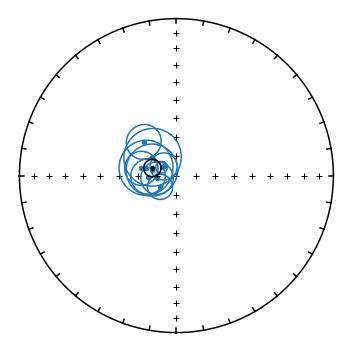

In [37]:
Jing2019_inc_flipped_ic = ipmag.unsquish(Jing2019_inc_flipped, 0.6)

Jing2019_site_mean_06 = ipmag.fisher_mean(Jing2019_dec_flipped,Jing2019_inc_flipped_ic)

ipmag.print_direction_mean(Jing2019_site_mean_06)

fignum = 1
plt.figure(num=fignum,figsize=(5,5))
ipmag.plot_net(fignum)
for j in range(len(Jing2019)):
    ipmag.plot_di_mean(Jing2019_dec_flipped[j], Jing2019_inc_flipped_ic[j], Jing2019_a95_flipped[j], color='C0')
ipmag.plot_di_mean(Jing2019_site_mean_06['dec'],
                   Jing2019_site_mean_06['inc'],
                   Jing2019_site_mean_06['alpha95'],
                   color='k')
plt.show()

In [38]:
print('site mean VGP, f = 0.6 - (lon, lat, dp, dm)')
Chengjiang_site_06_vgp = pmag.dia_vgp(Jing2019_site_mean_06['dec'],
                                      Jing2019_site_mean_06['inc'],
                                      Jing2019_site_mean_06['alpha95'],
                                      25.145,102.411)
Chengjiang_site_06_vgp

site mean VGP, f = 0.6 - (lon, lat, dp, dm)


(74.87591425837131, 29.99061271175446, 7.795518818464973, 8.368132429674855)

In [39]:
SChina.loc[i, 'name']    = 'Chengjiang Formation - site mean (f=0.6)'
SChina.loc[i, 'terrane'] = 'SChina'
SChina.loc[i, 'age']       = 799.5
SChina.loc[i, 'age upper'] = 799.5 + 8.4
SChina.loc[i, 'age lower'] = 799.5 - 8.4
SChina.loc[i, 'plat'] = Chengjiang_site_06_vgp[1]
SChina.loc[i, 'plon'] = Chengjiang_site_06_vgp[0]
SChina.loc[i, 'a95']  = np.sqrt(Chengjiang_site_06_vgp[2]*Chengjiang_site_06_vgp[3])
SChina.loc[i, 'f'] = 0.6
SChina.loc[i, 'slat'] = 25.145
SChina.loc[i, 'slon'] = 102.411
SChina.loc[i, 'dec']     = Jing2019_site_mean_06['dec']
SChina.loc[i, 'inc']     = Jing2019_site_mean_06['inc']
SChina.loc[i, 'dir_a95'] = Jing2019_site_mean_06['alpha95']
SChina.loc[i, 'pole ref'] = 'Jing et al. (2019)'
SChina.loc[i, 'age ref']  = 'Jing et al. (2019)'
SChina.loc[i, 'grade'] = 'NR'
SChina.loc[i, 'note']  = '-'
SChina.loc[i, 'plateID'] = 602
i = i + 1

### Liantuo Formation

* Two versions of the pole: grand mean pole of Evans et al. (2000) and Jing et al. (2015), similar to just the Jing et al. (2015) pole.
* Preliminary TIMS on tuff is 778 Ma - redated from 748 ± 12 Ma in Ma et al. (1984)
* But Jing et al. (2015) prefers an age of ~720 Ma based on SIMS ages from the upper Liantuo Formation (Lan et al. 2015)

In [40]:
Liantuo_site_dec = 102.5
Liantuo_site_inc = 62.4
Liantuo_site_a95 = 3.7
Liantuo_site_slat = 30.819
Liantuo_site_slon = 111.069

SChina.loc[i, 'name']    = 'Liantuo Formation - Jing et al. (2015) (f=1.0)'
SChina.loc[i, 'terrane'] = 'SChina'
SChina.loc[i, 'age']       = 750
SChina.loc[i, 'age upper'] = 780
SChina.loc[i, 'age lower'] = 720
SChina.loc[i, 'plat'] = 12.7
SChina.loc[i, 'plon'] = 157.4
SChina.loc[i, 'a95']  = np.sqrt(4.5*5.8)
SChina.loc[i, 'f'] = 1.0
SChina.loc[i, 'slat'] = Liantuo_site_slat
SChina.loc[i, 'slon'] = Liantuo_site_slon
SChina.loc[i, 'dec']     = Liantuo_site_dec
SChina.loc[i, 'inc']     = Liantuo_site_inc
SChina.loc[i, 'dir_a95'] = Liantuo_site_a95
SChina.loc[i, 'pole ref'] = 'Jing et al. (2015)'
SChina.loc[i, 'age ref']  = 'Ma et al. (1984)'
SChina.loc[i, 'grade'] = 'B'
SChina.loc[i, 'note']  = '-'
SChina.loc[i, 'plateID'] = 602
i = i + 1

Do an inclination correction:

In [41]:
Liantuo_site_inc_unsquished = ipmag.unsquish([Liantuo_site_inc],0.6)[0]

Liantuo_site_vgp_unsquished = pmag.dia_vgp(Liantuo_site_dec,
                                           Liantuo_site_inc_unsquished,
                                           Liantuo_site_a95,
                                           Liantuo_site_slat,
                                           Liantuo_site_slon)

SChina.loc[i, 'name']    = 'Liantuo Formation - Jing et al. (2015) (f=0.6)'
SChina.loc[i, 'terrane'] = 'SChina'
SChina.loc[i, 'age']       = 750
SChina.loc[i, 'age upper'] = 780
SChina.loc[i, 'age lower'] = 720
SChina.loc[i, 'plat'] = Liantuo_site_vgp_unsquished[1]
SChina.loc[i, 'plon'] = Liantuo_site_vgp_unsquished[0]
SChina.loc[i, 'a95']  = np.sqrt(Liantuo_site_vgp_unsquished[2]*Liantuo_site_vgp_unsquished[3])
SChina.loc[i, 'f'] = 0.6
SChina.loc[i, 'slat'] = Liantuo_site_slat
SChina.loc[i, 'slon'] = Liantuo_site_slon
SChina.loc[i, 'dec']     = Liantuo_site_dec
SChina.loc[i, 'inc']     = Liantuo_site_inc_unsquished
SChina.loc[i, 'dir_a95'] = Liantuo_site_a95
SChina.loc[i, 'pole ref'] = 'Jing et al. (2015)'
SChina.loc[i, 'age ref']  = 'Ma et al. (1984)'
SChina.loc[i, 'grade'] = 'B'
SChina.loc[i, 'note']  = '-'
SChina.loc[i, 'plateID'] = 602
i = i + 1

Grand mean version of the pole:

In [42]:
Liantuo_GM_site_dec = np.nan
Liantuo_GM_site_inc = np.nan
Liantuo_GM_site_a95 = np.nan
Liantuo_GM_site_slat = 30.819
Liantuo_GM_site_slon = 111.069

SChina.loc[i, 'name']    = 'Liantuo Formation - grand mean (f=1.0)'
SChina.loc[i, 'terrane'] = 'SChina'
SChina.loc[i, 'age']       = 750
SChina.loc[i, 'age upper'] = 780
SChina.loc[i, 'age lower'] = 720
SChina.loc[i, 'plat'] = 13.2
SChina.loc[i, 'plon'] = 155.2
SChina.loc[i, 'a95']  = 5.3
SChina.loc[i, 'f'] = 1.0
SChina.loc[i, 'slat'] = Liantuo_GM_site_slat
SChina.loc[i, 'slon'] = Liantuo_GM_site_slon
SChina.loc[i, 'dec']     = Liantuo_GM_site_dec
SChina.loc[i, 'inc']     = Liantuo_GM_site_inc
SChina.loc[i, 'dir_a95'] = Liantuo_GM_site_a95
SChina.loc[i, 'pole ref'] = 'Evans et al. (2000), Jing et al. (2015)'
SChina.loc[i, 'age ref']  = 'Ma et al. (1984)'
SChina.loc[i, 'grade'] = 'B'
SChina.loc[i, 'note']  = '-'
SChina.loc[i, 'plateID'] = 602
i = i + 1

### APWP

In [43]:
SChina.sort_values('age', ascending=False, inplace=True)
SChina = SChina[compilation_cols]
SChina.reset_index(inplace=True, drop=True)
SChina

,name,terrane,age,age upper,age lower,plat,plon,a95,f,slat,slon,dec,inc,dir_a95,pole ref,age ref,grade,note,plateID
0,Yanbian Dikes Group A,SChina,824,830,818,45.1,130.4,19,1,26.886,101.546,NaN,NaN,NaN,Niu et al. (2016),Niu et al. (2016),B,-,602
1,Xiaofeng Dikes - Li et al. (2004),SChina,821,821.84,820.9,13.5,91,10.8927,1,30.96,111.23,231.3,76.6,6.1,Li et al. (2004),Wang et al. (2016),B,-,602
2,Xiaofeng Dikes - Jing et al. (2019),SChina,821,821.84,820.9,26.1,82.1,14.5877,1,30.96,111.23,266.5,76.3,8.2,Jing et al. (2019),Wang et al. (2016),B,-,602
3,Banxi Group - site mean (f=1.0),SChina,814,815,813,51.7,99.9,12.4419,1,27.91,108.82,346.7,77,6.9,this study,this study,NR,-,602
4,Banxi Group - specimen mean (f=1.0),SChina,814,815,813,53,107.6,7.64591,1,27.91,108.82,358.3,76.8,4.3,this study,this study,NR,-,602
5,Banxi Group - specimen mean (f=0.6),SChina,814,815,813,44.6,108.5,5.39907,0.6,27.91,108.82,359.2,81.5,2.8,this study,this study,NR,-,602
6,Banxi Group - Luoman specimen mean (f=0.6),SChina,814,815,813,40.2,111.2,8.54985,0.6,27.91,108.82,8.5,83.7,4.4,this study,this study,NR,-,602
7,Banxi Group - Mamaguo specimen mean (f=0.6),SChina,814,815,813,42.1,92.7,8.34865,0.6,27.91,108.82,321.5,80,4.5,this study,this study,NR,-,602
8,Banxi Group - site mean (f=0.6),SChina,814,815,813,43,104,8.19939,0.6,27.91,108.82,346.8,82,4.3,this study,this study,NR,-,602
9,Madiyi Formation - site mean (f=1.0),SChina,804.9,805.26,804.54,35.7079,66.237,9.122,1,27.5,109.6,293.732,68.9961,5.82433,Xian et al. (2020),this study,NR,-,602


In [44]:
SChina.to_csv('../Output/SChina-poles.csv',index=False)
SChina_vpgFeatureCollection = create_vgp_FeatureCollection(SChina)
create_vgp_gpml(SChina_vpgFeatureCollection, '../Output/SChina-poles.gpml')

Palaeomagnetic pole data successfully exported in GPML format.


All the poles, colored by age:

In [45]:
def SChina_APWP_plot(df, title=None, savefig=None):
    
    lat_grid = [-80,-60,-30,0,30,60,80]
    lon_grid = np.arange(-180,180+60,60)

    ax = ipmag.make_orthographic_map(add_land=False, central_longitude=115, central_latitude=45,
                                     figsize=(7,7), grid_lines=False)

    ax.add_feature(cartopy.feature.LAND, zorder=-99,
                   facecolor='#dddddd', edgecolor='none')

    color_mapping = plt.cm.ScalarMappable(cmap='viridis',
                                          norm=plt.Normalize(vmin=np.min(df['age']),
                                                             vmax=np.max(df['age'])))
    colors = color_mapping.to_rgba(df['age'].tolist()).tolist()

    for i in range(len(df)):
        rotated_pole_plot(ax, df['plon'][i], df['plat'][i], df['a95'][i], [[0,0,0]],
                          'o', 20, 'C7', colors[i], 0.5)

    ax.gridlines(xlocs=lon_grid, ylocs=lat_grid, linewidth=0.5,
                 color='C7', linestyle='dotted', zorder=-1)
    
    if title!=None:
        ax.set_title(title)

    color_mapping._A = []
    cbar = plt.colorbar(color_mapping, orientation='horizontal', shrink=0.8,
                        pad=0.05, label='age [Ma]')
    cbar.ax.invert_xaxis()

    if savefig!=None:
        plt.savefig(savefig, bbox_inches='tight')
        
    plt.show()

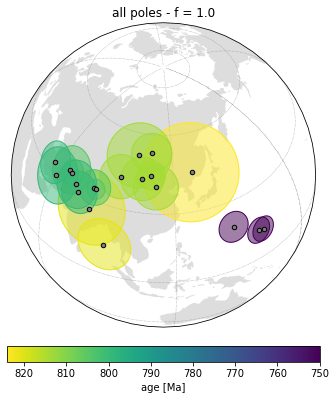

In [46]:
SChina_APWP_plot(SChina, title='all poles - f = 1.0')

Directions at the Banxi Group site:

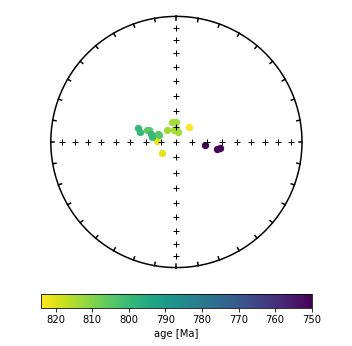

In [47]:
# approximately the mean coordinates of all sites on the E side of the mountains
slat = 27.91
slon = 108.82

# convert pole position to a direction at our Banxi sites
decs = np.array([])
incs = np.array([])
for i in range(len(SChina.index)):
    dec, inc = pmag.vgp_di(SChina['plat'][i], SChina['plon'][i], slat, slon)
    decs = np.append(decs, dec)
    incs = np.append(incs, inc)

# add to dataframe
SChina['Banxi_dec'] = np.round(decs,1)
SChina['Banxi_inc'] = np.round(incs,1)

color_mapping = plt.cm.ScalarMappable(cmap='viridis',
                                      norm=plt.Normalize(vmin=np.min(SChina['age']),
                                                         vmax=np.max(SChina['age'])))
colors = color_mapping.to_rgba(SChina['age'].tolist()).tolist()

fignum = 1
plt.figure(num=fignum,figsize=(5,5))
ipmag.plot_net(fignum)

for i in range(len(decs)):
    ipmag.plot_di(dec=decs[i],inc=incs[i],color=colors[i],markersize=40)
    
color_mapping._A = []
cbar = plt.colorbar(color_mapping, orientation='horizontal', shrink=0.8,
                    pad=0.05, label='age [Ma]')
cbar.ax.invert_xaxis()

plt.show()

Pull out some subsets of the data:

In [48]:
select_poles = ['Yanbian Dikes Group A',
                'Xiaofeng Dikes - Jing et al. (2019)',
                'Banxi Group - specimen mean (f=1.0)',
                'Madiyi Formation - specimen mean (f=1.0)',
                'Chengjiang Formation - specimen mean (f=1.0)',
                'Liantuo Formation - Jing et al. (2015) (f=1.0)']

SChina_spec_10 = SChina[SChina['name'].isin(select_poles)]
SChina_spec_10.reset_index(drop=True, inplace=True)

In [49]:
select_poles = ['Xiaofeng Dikes - Jing et al. (2019)',
                'Banxi Group - specimen mean (f=0.6)',
                'Madiyi Formation - specimen mean (f=0.6)',
                'Chengjiang Formation - specimen mean (f=0.6)',
                'Liantuo Formation - Jing et al. (2015) (f=0.6)']

SChina_spec_06a = SChina[SChina['name'].isin(select_poles)]
SChina_spec_06a.reset_index(drop=True, inplace=True)

In [50]:
select_poles = ['Xiaofeng Dikes - Jing et al. (2019)',
                'Banxi Group - Luoman specimen mean (f=0.6)',
                'Banxi Group - Mamaguo specimen mean (f=0.6)',
                'Madiyi Formation - specimen mean (f=0.6)',
                'Chengjiang Formation - specimen mean (f=0.6)',
                'Liantuo Formation - Jing et al. (2015) (f=0.6)']

SChina_spec_06b = SChina[SChina['name'].isin(select_poles)]
SChina_spec_06b.reset_index(drop=True, inplace=True)

In [51]:
select_poles = ['Xiaofeng Dikes - Jing et al. (2019)',
                'Banxi Group - site mean (f=1.0)',
                'Madiyi Formation - site mean (f=1.0)',
                'Chengjiang Formation - site mean (f=1.0)',
                'Liantuo Formation - Jing et al. (2015) (f=1.0)']

SChina_site_10 = SChina[SChina['name'].isin(select_poles)]
SChina_site_10.reset_index(drop=True, inplace=True)

In [52]:
select_poles = ['Xiaofeng Dikes - Jing et al. (2019)',
                'Banxi Group - site mean (f=0.6)',
                'Madiyi Formation - site mean (f=0.6)',
                'Chengjiang Formation - site mean (f=0.6)',
                'Liantuo Formation - Jing et al. (2015) (f=0.6)']

SChina_site_06 = SChina[SChina['name'].isin(select_poles)]
SChina_site_06.reset_index(drop=True, inplace=True)

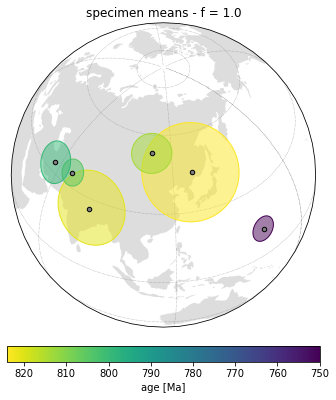

In [53]:
SChina_APWP_plot(SChina_spec_10, title='specimen means - f = 1.0', savefig='../Output/SChina_APWP_f_10_spec.pdf')

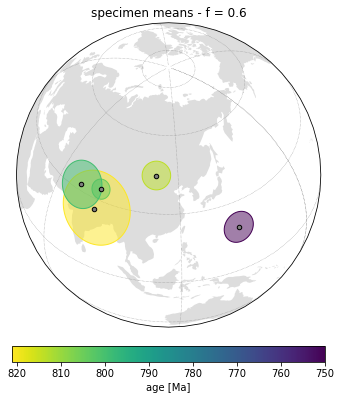

In [54]:
SChina_APWP_plot(SChina_spec_06a, title='specimen means - f = 0.6')

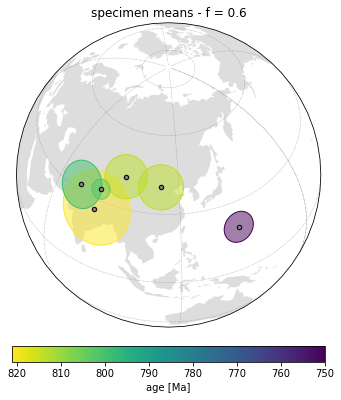

In [55]:
SChina_APWP_plot(SChina_spec_06b, title='specimen means - f = 0.6')

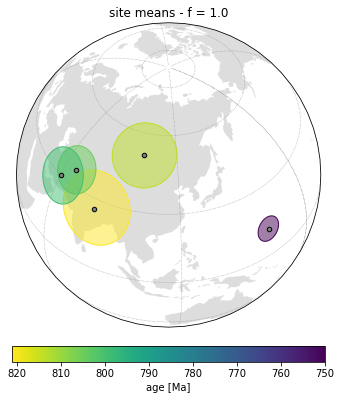

In [56]:
SChina_APWP_plot(SChina_site_10, title='site means - f = 1.0', savefig='../Output/SChina_APWP_f_10.pdf')

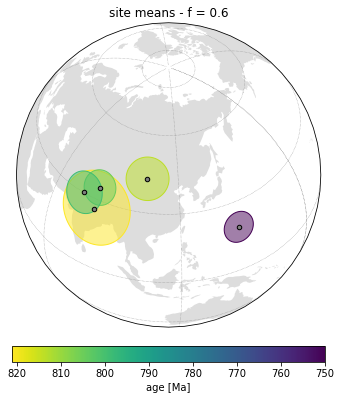

In [57]:
SChina_APWP_plot(SChina_site_06, title='site means - f = 0.6', savefig='../Output/SChina_APWP_f_06.pdf')

In [58]:
SChina_site_06.to_csv('../Output/SChina-clean-poles.csv',index=False)
SChina_clean_vpgFeatureCollection = create_vgp_FeatureCollection(SChina_site_06)
create_vgp_gpml(SChina_clean_vpgFeatureCollection, '../Output/SChina-clean-poles.gpml')

Palaeomagnetic pole data successfully exported in GPML format.


APWP to minimize movement of SChina:

In [59]:
# rotate SChina to India
SChina_India_Euler = [1.98,74.44,40.29]

# India rotations
India_Eulers = [[-37.9969,-51.2888,66.6023],
                [-39.484,-51.29,64.9233],
                [-36.1828,-53.5503,67.2318],
                [-32.4513,-54.6557,71.4361],
                [-59.1154,0.1916,69.2928]]

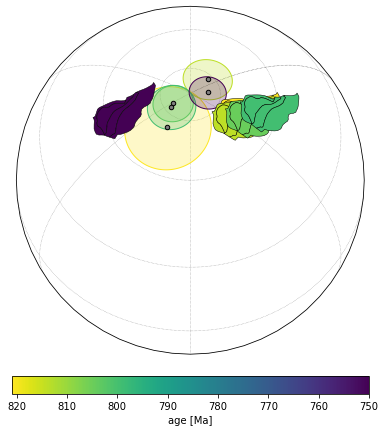

In [60]:
ax = ipmag.make_orthographic_map(add_land=False, central_longitude=60, central_latitude=60,
                                 figsize=(8,8), grid_lines=False)

lat_grid = [-80,-60,-30,0,30,60,80]
lon_grid = np.arange(-180,180+60,60)

color_mapping = plt.cm.ScalarMappable(cmap='viridis',
                                      norm=plt.Normalize(vmin=np.min(SChina_site_06['age']),
                                                         vmax=np.max(SChina_site_06['age'])))
pole_colors = color_mapping.to_rgba(SChina_site_06['age'].tolist()).tolist()

for i in range(len(SChina_site_06)):
    rotated_pole_plot(ax, SChina_site_06['plon'][i], SChina_site_06['plat'][i], SChina_site_06['a95'][i],
                      [SChina_India_Euler,India_Eulers[i]],
                      'o', 20, 'C7', pole_colors[i], 0.25)

for i in range(len(India_Eulers)):
    craton_plot(ax, [6024], [SChina_India_Euler,India_Eulers[i]], 'k', pole_colors[i], 1.0, 0.5)
    craton_plot(ax, [6023], [SChina_India_Euler,India_Eulers[i]], 'k', pole_colors[i], 1.0, 0.5)
    craton_plot(ax, [602], [SChina_India_Euler,India_Eulers[i]], 'k', pole_colors[i], 1.0, 0.5)
    
ax.gridlines(xlocs=lon_grid, ylocs=lat_grid, linewidth=0.5,
             color='C7', linestyle='dotted', zorder=-1)
    
color_mapping._A = []
cbar = plt.colorbar(color_mapping, orientation='horizontal', shrink=0.8,
                    pad=0.05, label='age [Ma]')
cbar.ax.invert_xaxis()

plt.savefig('../Output/SChina_reconstructed.pdf', bbox_inches='tight')
plt.show()

APWP using the means:

In [61]:
# rotate SChina to India
SChina_India_Euler = [1.98,74.44,40.29]

# India rotations
India_Eulers = [[-31.2507,-49.3398,78.0125],
                [-45.756,-51.2532,59.6451],
                [-32.681,-55.4336,72.3265],
                [-28.9147,-55.8921,77.9811],
                [-60.4426,8.8533,72.284]]

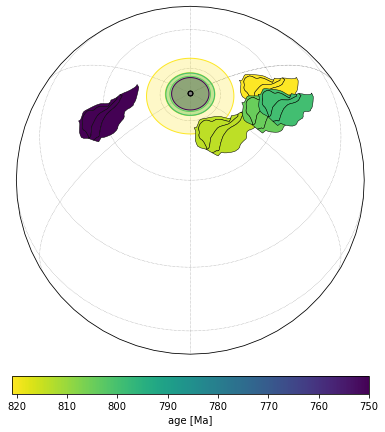

In [62]:
ax = ipmag.make_orthographic_map(add_land=False, central_longitude=60, central_latitude=60,
                                 figsize=(8,8), grid_lines=False)

lat_grid = [-80,-60,-30,0,30,60,80]
lon_grid = np.arange(-180,180+60,60)

color_mapping = plt.cm.ScalarMappable(cmap='viridis',
                                      norm=plt.Normalize(vmin=np.min(SChina_site_06['age']),
                                                         vmax=np.max(SChina_site_06['age'])))
pole_colors = color_mapping.to_rgba(SChina_site_06['age'].tolist()).tolist()

for i in range(len(SChina_site_06)):
    rotated_pole_plot(ax, SChina_site_06['plon'][i], SChina_site_06['plat'][i], SChina_site_06['a95'][i],
                      [SChina_India_Euler,India_Eulers[i]],
                      'o', 20, 'C7', pole_colors[i], 0.25)

for i in range(len(India_Eulers)):
    craton_plot(ax, [6024], [SChina_India_Euler,India_Eulers[i]], 'k', pole_colors[i], 1.0, 0.5)
    craton_plot(ax, [6023], [SChina_India_Euler,India_Eulers[i]], 'k', pole_colors[i], 1.0, 0.5)
    craton_plot(ax, [602], [SChina_India_Euler,India_Eulers[i]], 'k', pole_colors[i], 1.0, 0.5)
    
ax.gridlines(xlocs=lon_grid, ylocs=lat_grid, linewidth=0.5,
             color='C7', linestyle='dotted', zorder=-1)
    
color_mapping._A = []
cbar = plt.colorbar(color_mapping, orientation='horizontal', shrink=0.8,
                    pad=0.05, label='age [Ma]')
cbar.ax.invert_xaxis()

plt.savefig('../Output/SChina_reconstructed_mean.pdf', bbox_inches='tight')
plt.show()

APWP to maximize distance between Banxi and Madiyi poles:

In [63]:
# rotate SChina to India
SChina_India_Euler = [1.98,74.44,40.29]

# India rotations
India_Eulers = [[-31.2507,-49.3398,78.0125],
                [-52.6572,-48.2693,55.414],
                [-29.0891,-56.2597,77.362],
                [-28.9147,-55.8921,77.9811],
                [-60.4426,8.8533,72.284]]

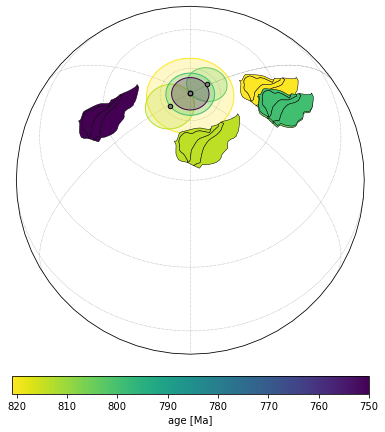

In [64]:
ax = ipmag.make_orthographic_map(add_land=False, central_longitude=60, central_latitude=60,
                                 figsize=(8,8), grid_lines=False)

lat_grid = [-80,-60,-30,0,30,60,80]
lon_grid = np.arange(-180,180+60,60)

color_mapping = plt.cm.ScalarMappable(cmap='viridis',
                                      norm=plt.Normalize(vmin=np.min(SChina_site_06['age']),
                                                         vmax=np.max(SChina_site_06['age'])))
pole_colors = color_mapping.to_rgba(SChina_site_06['age'].tolist()).tolist()

for i in range(len(SChina_site_06)):
    rotated_pole_plot(ax, SChina_site_06['plon'][i], SChina_site_06['plat'][i], SChina_site_06['a95'][i],
                      [SChina_India_Euler,India_Eulers[i]],
                      'o', 20, 'C7', pole_colors[i], 0.25)

for i in range(len(India_Eulers)):
    craton_plot(ax, [6024], [SChina_India_Euler,India_Eulers[i]], 'k', pole_colors[i], 1.0, 0.5)
    craton_plot(ax, [6023], [SChina_India_Euler,India_Eulers[i]], 'k', pole_colors[i], 1.0, 0.5)
    craton_plot(ax, [602], [SChina_India_Euler,India_Eulers[i]], 'k', pole_colors[i], 1.0, 0.5)
    
ax.gridlines(xlocs=lon_grid, ylocs=lat_grid, linewidth=0.5,
             color='C7', linestyle='dotted', zorder=-1)
    
color_mapping._A = []
cbar = plt.colorbar(color_mapping, orientation='horizontal', shrink=0.8,
                    pad=0.05, label='age [Ma]')
cbar.ax.invert_xaxis()

plt.savefig('../Output/SChina_reconstructed_TPW.pdf', bbox_inches='tight')
plt.show()

### Drift Rate

In [65]:
def great_circle_distance(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points using the Haversine formula.
    
    Parameters
    ----------
    lon1 : float
        Longitude of point 1.
    lat1 : float
        Latitude of point 1.
    lon2 : float
        Longitude of point 2.
    lat2 : float
        Latitude of point 2.
        
    Returns
    -------
    dist : float
        Great circle distance in meters.
    """
    # mean Earth radius, in meters
    R = 6371e3
    
    # convert to radians
    lon1_rad = np.deg2rad(lon1)
    lat1_rad = np.deg2rad(lat1)
    lon2_rad = np.deg2rad(lon2)
    lat2_rad = np.deg2rad(lat2)
    
    # differences
    delta_lon = np.deg2rad(lon2 - lon1)
    delta_lat = np.deg2rad(lat2 - lat1)
    
    # haversine formula
    a = (np.sin(delta_lat/2)**2) + np.cos(lat1_rad)*np.cos(lat2_rad)*(np.sin(delta_lon/2)**2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    dist = R * c
    
    return dist

In [66]:
def plate_rate_mc(pole1_plon, pole1_plat, pole1_kappa, pole1_N, pole1_age, pole1_MCages,
                  pole2_plon, pole2_plat, pole2_kappa, pole2_N, pole2_age, pole2_MCages,
                  ref_loc_lon, ref_loc_lat, samplesize=10000, random_seed=None):
    """
    Determine the latitudinal motion implied by a pair of poles and utilize
    the Monte Carlo sampling method of Swanson-Hysell (2014) to determine the
    associated uncertainty.
    
    Modified from PmagPy.

    Parameters:
    ------------
    plon : longitude of pole
    plat : latitude of pole
    kappa : Fisher precision parameter for VPGs in pole
    N : number of VGPs in pole
    age : age assigned to pole in Ma
    MCages : MC sampled age distribution - must have same length as samplesize
    ref_loc_lon : longitude of reference location
    ref_loc_lat : latitude of reference location
    samplesize : number of draws from pole and age distributions (default set to 10000)
    random_seed : set random seed for reproducible number generation (default is None)

    Returns
    --------
    rate : rate of latitudinal motion in cm/yr along with estimated 2.5 and 97.5
    percentile rate estimates
    """
    angle = pmag.angle([pole1_plon,pole1_plat],[pole2_plon,pole2_plat])
    print('angular difference between the means = {:.2f}'.format(angle[0]))
    
    ref_loc = [ref_loc_lon, ref_loc_lat]
    pole1 = (pole1_plon, pole1_plat)
    pole1_paleolat = 90 - pmag.angle(pole1, ref_loc)
    pole2 = (pole2_plon, pole2_plat)
    pole2_paleolat = 90 - pmag.angle(pole2, ref_loc)
    print('paleolatitude for ref_loc resulting from the mean of pole1 = {:.2f}'.format(pole1_paleolat[0]))
    print('paleolatitude for ref_loc resulting from the mean of pole2 = {:.2f}'.format(pole2_paleolat[0]))
    rate = (great_circle_distance(0,pole1_paleolat,0,pole2_paleolat)*1e2) / ((pole1_age-pole2_age)*1e6)
    print('rate of paleolatitudinal change implied by the means = {:.2f} cm/yr'.format(rate[0]))
    plate_rate = (great_circle_distance(pole1_plon,
                                        pole1_plat,
                                        pole2_plon,
                                        pole2_plat)*1e2) / ((pole1_age-pole2_age)*1e6)
    print('plate velocity implied by the means = {:.2f} cm/yr'.format(plate_rate))

    if random_seed != None:
        np.random.seed(random_seed)

    pole1_MCpoles = []
    pole1_MCpole_lat = []
    pole1_MCpole_long = []
    pole1_MCpaleolat = []
    for n in range(samplesize):
        vgp_samples = []
        for vgp in range(pole1_N):
            # pmag.dev returns a direction from a fisher distribution with
            # specified kappa
            direction_atN = pmag.fshdev(pole1_kappa)
            # this direction is centered at latitude of 90 degrees and needs to be rotated
            # to be centered on the mean pole position
            tilt_direction = pole1_plon
            tilt_amount = 90 - pole1_plat
            direction = pmag.dotilt(direction_atN[0], direction_atN[1], tilt_direction, tilt_amount)
            vgp_samples.append([direction[0], direction[1], 1.])
        mean = pmag.fisher_mean(vgp_samples)
        mean_pole_position = (mean['dec'], mean['inc'])
        pole1_MCpoles.append([mean['dec'], mean['inc'], 1.])
        pole1_MCpole_lat.append(mean['inc'])
        pole1_MCpole_long.append(mean['dec'])
        paleolat = 90 - pmag.angle(mean_pole_position, ref_loc)
        pole1_MCpaleolat.append(paleolat[0])

    pole2_MCpoles = []
    pole2_MCpole_lat = []
    pole2_MCpole_long = []
    pole2_MCpaleolat = []
    for n in range(samplesize):
        vgp_samples = []
        for vgp in range(pole2_N):
            # pmag.dev returns a direction from a fisher distribution with
            # specified kappa
            direction_atN = pmag.fshdev(pole2_kappa)
            # this direction is centered at latitude of 90 degrees and needs to be rotated
            # to be centered on the mean pole position
            tilt_direction = pole2_plon
            tilt_amount = 90 - pole2_plat
            direction = pmag.dotilt(
                direction_atN[0], direction_atN[1], tilt_direction, tilt_amount)
            vgp_samples.append([direction[0], direction[1], 1.])
        mean = pmag.fisher_mean(vgp_samples)
        mean_pole_position = (mean['dec'], mean['inc'])
        pole2_MCpoles.append([mean['dec'], mean['inc'], 1.])
        pole2_MCpole_lat.append(mean['inc'])
        pole2_MCpole_long.append(mean['dec'])
        paleolat = 90 - pmag.angle(mean_pole_position, ref_loc)
        pole2_MCpaleolat.append(paleolat[0])

    # calculating the change in paleolatitude and angle between the Monte Carlo pairs
    MC_angular_degrees = []
    MC_angular_degrees_per_myr = []
    MC_angular_cm_per_yr = []
    MC_paleolat_degrees = []
    MC_paleolat_degrees_per_myr = []
    MC_paleolat_cm_per_yr = []

    for n in range(samplesize):
        angular_degrees = pmag.angle([pole1_MCpole_long[n],pole1_MCpole_lat[n]],
                                     [pole2_MCpole_long[n],pole2_MCpole_lat[n]])
        MC_angular_degrees.append(angular_degrees[0])
        
        paleolat_degrees = pole1_MCpaleolat[n] - pole2_MCpaleolat[n]
        MC_paleolat_degrees.append(paleolat_degrees)
        
        Delta_Myr = pole1_MCages[n] - pole2_MCages[n]
        
        angular_degrees_per_myr = angular_degrees[0] / Delta_Myr
        MC_angular_degrees_per_myr.append(angular_degrees_per_myr)
        
        angular_cm_per_yr = (great_circle_distance(pole1_MCpole_long[n],
                                                   pole1_MCpole_lat[n],
                                                   pole2_MCpole_long[n],
                                                   pole2_MCpole_lat[n])*1e2) / (Delta_Myr*1e6)
        MC_angular_cm_per_yr.append(angular_cm_per_yr)
        
        paleolat_degrees_per_myr = paleolat_degrees / Delta_Myr
        MC_paleolat_degrees_per_myr.append(paleolat_degrees_per_myr)
        
        paleolat_cm_per_yr = (great_circle_distance(0,paleolat_degrees,0,0)*1e2) / (Delta_Myr*1e6)
        MC_paleolat_cm_per_yr.append(paleolat_cm_per_yr)

    perc_02_5 = stats.scoreatpercentile(MC_paleolat_cm_per_yr, 2.5)
    perc_50_0 = stats.scoreatpercentile(MC_paleolat_cm_per_yr, 50)
    perc_97_5 = stats.scoreatpercentile(MC_paleolat_cm_per_yr, 97.5)
    
    output = pd.DataFrame({'pole1_MC_ages':pole1_MCages,
                           'pole2_MC_ages':pole2_MCages,
                           'pole1_MC_plat':pole1_MCpole_lat,
                           'pole1_MC_plon':pole1_MCpole_long,
                           'pole1_MC_paleolat':pole1_MCpaleolat,
                           'pole2_MC_plat':pole2_MCpole_lat,
                           'pole2_MC_plon':pole2_MCpole_long,
                           'pole2_MC_paleolat':pole2_MCpaleolat,
                           'angular_degrees':MC_angular_degrees,
                           'angular_degrees_per_myr':MC_angular_degrees_per_myr,
                           'angular_cm_per_yr':MC_angular_cm_per_yr,
                           'paleolat_degrees':MC_paleolat_degrees,
                           'paleolat_degrees_per_myr':MC_paleolat_degrees_per_myr,
                           'paleolat_cm_per_yr':MC_paleolat_cm_per_yr,})
    
    return output

samplesize=10000

Between Xiaofeng Dikes and Banxi Group:

In [67]:
np.random.seed(2020)

pole1_slice = SChina[SChina['name']=='Xiaofeng Dikes - Jing et al. (2019)']
pole2_slice = SChina[SChina['name']=='Banxi Group - site mean (f=0.6)']

pole1_plon = pole1_slice['plon'].iloc[0]
pole1_plat = pole1_slice['plat'].iloc[0]
pole1_kappa = 35.3
pole1_N = 10
pole1_age = pole1_slice['age'].iloc[0]
pole1_age_error = pole1_slice['age upper'].iloc[0] - pole1_slice['age'].iloc[0]
pole1_MCages = np.random.normal(pole1_age, pole1_age_error, samplesize)

pole2_plon = pole2_slice['plon'].iloc[0]
pole2_plat = pole2_slice['plat'].iloc[0]
pole2_kappa = 80.9
pole2_N = 15
pole2_age = pole2_slice['age'].iloc[0]
pole2_age_error = (pole2_slice['age upper'].iloc[0] - pole2_slice['age'].iloc[0])/2
pole2_MCages = np.random.normal(pole2_age, pole2_age_error, samplesize)

XF_BX = plate_rate_mc(pole1_plon,pole1_plat,pole1_kappa,pole1_N,pole1_age,pole1_MCages,
                      pole2_plon,pole2_plat,pole2_kappa,pole2_N,pole2_age,pole2_MCages,
                      108.82,27.91,
                      samplesize=samplesize, random_seed=2020)

angular difference between the means = 24.57
paleolatitude for ref_loc resulting from the mean of pole1 = 66.17
paleolatitude for ref_loc resulting from the mean of pole2 = 74.41
rate of paleolatitudinal change implied by the means = 13.09 cm/yr
plate velocity implied by the means = 39.04 cm/yr


Between Banxi Group and Madiyi Formation:

In [68]:
np.random.seed(2020)

pole1_slice = SChina[SChina['name']=='Banxi Group - site mean (f=0.6)']
pole2_slice = SChina[SChina['name']=='Madiyi Formation - site mean (f=0.6)']

pole1_plon = pole1_slice['plon'].iloc[0]
pole1_plat = pole1_slice['plat'].iloc[0]
pole1_kappa = 80.9
pole1_N = 15
pole1_age = pole1_slice['age'].iloc[0]
pole1_age_error = (pole1_slice['age upper'].iloc[0] - pole1_slice['age'].iloc[0])/2
pole1_MCages = np.random.normal(pole1_age, pole1_age_error, samplesize)

pole2_plon = pole2_slice['plon'].iloc[0]
pole2_plat = pole2_slice['plat'].iloc[0]
pole2_kappa = 135.5
pole2_N = 12
pole2_age = pole2_slice['age'].iloc[0]
pole2_age_error = (pole2_slice['age upper'].iloc[0] - pole2_slice['age'].iloc[0])/2
pole2_MCages = np.random.normal(pole2_age, pole2_age_error, samplesize)

BX_MY = plate_rate_mc(pole1_plon,pole1_plat,pole1_kappa,pole1_N,pole1_age,pole1_MCages,
                      pole2_plon,pole2_plat,pole2_kappa,pole2_N,pole2_age,pole2_MCages,
                      108.82,27.91,
                      samplesize=samplesize, random_seed=2020)

angular difference between the means = 19.32
paleolatitude for ref_loc resulting from the mean of pole1 = 74.41
paleolatitude for ref_loc resulting from the mean of pole2 = 65.81
rate of paleolatitudinal change implied by the means = 10.52 cm/yr
plate velocity implied by the means = 23.61 cm/yr


Between Luoman of the Banxi Group and the Madiyi Formation:

In [69]:
np.random.seed(2020)

pole1_slice = SChina[SChina['name']=='Banxi Group - Luoman specimen mean (f=0.6)']
pole2_slice = SChina[SChina['name']=='Madiyi Formation - site mean (f=0.6)']

pole1_plon = pole1_slice['plon'].iloc[0]
pole1_plat = pole1_slice['plat'].iloc[0]
pole1_kappa = 14.3
pole1_N = 78
pole1_age = pole1_slice['age'].iloc[0]
pole1_age_error = (pole1_slice['age upper'].iloc[0] - pole1_slice['age'].iloc[0])/2
pole1_MCages = np.random.normal(pole1_age, pole1_age_error, samplesize)

pole2_plon = pole2_slice['plon'].iloc[0]
pole2_plat = pole2_slice['plat'].iloc[0]
pole2_kappa = 135.5
pole2_N = 12
pole2_age = pole2_slice['age'].iloc[0]
pole2_age_error = (pole2_slice['age upper'].iloc[0] - pole2_slice['age'].iloc[0])/2
pole2_MCages = np.random.normal(pole2_age, pole2_age_error, samplesize)

LM_MY = plate_rate_mc(pole1_plon,pole1_plat,pole1_kappa,pole1_N,pole1_age,pole1_MCages,
                      pole2_plon,pole2_plat,pole2_kappa,pole2_N,pole2_age,pole2_MCages,
                      108.82,27.91,
                      samplesize=samplesize, random_seed=2020)

angular difference between the means = 24.09
paleolatitude for ref_loc resulting from the mean of pole1 = 77.55
paleolatitude for ref_loc resulting from the mean of pole2 = 65.81
rate of paleolatitudinal change implied by the means = 14.35 cm/yr
plate velocity implied by the means = 29.44 cm/yr


Between Lower Grus. and Upper Grus. poles from Svalbard:

Note that we do not apply an inclination correction to these poles, because they are derived from platform carbonates.

First, estimate age of poles using the thermal subsidence model in Maloof et al. (2016):

* Lower Grus. paleomagnetic data derived from within ~70m below boundary G1
* Upper Grus. paleomagnetic data derived from within ~25m above boundary G1
* In this section, Akademikerbreen Group is ~2000m thick, and from chemostratigraphic correlation the top is ~750 Ma, with generous uncertainty of ~740-760 Ma
* G1 at 810 Ma, ~550m into the Akademikerbreen
* S1 at 790 Ma, ~850m into the Akademikerbreen

In [70]:
y_sr = 4e3 #m
y_st = 2e3 #m
y_c = 35e3 #m
y_l = 100e3 #m
rho_sr = 2060 #kg/m3
rho_st = 2500 #kg/m3
rho_c = 2700 #kg/m3
rho_m = 3300 #kg/m3
T_0 = 0 #C
T_m = 1333 #C
alpha = 3.28e-5 #1/C
kappa = 1e-6 # m2/s

T_c = ((T_m-T_0)/2) * (y_c/y_l)
T_sc = 0.5 * (T_m + (y_c/y_l)*(T_m-T_0))
rho_sc = 2950 #kg/m3

t_total = 150 #m.y.
my_s = 1e6*365.25*24*60*60
t = np.linspace(0, t_total*my_s, 500) #s

rho_c_T = rho_c * (1 - alpha*T_c)
rho_sc_T = rho_sc * (1 - alpha*T_sc)
rho_m_T = rho_m * (1 - alpha*T_m)

#beta = (rho_c_T*y_c + rho_sc_T*(y_l-y_c) - rho_m_T*y_l) / \
#       (rho_c_T*y_c + rho_sc_T*(y_l-y_c) - rho_sr*y_sr + rho_m_T*(y_sr-y_l))

beta = 1.35

E_0 = (4*y_l*rho_m*alpha*T_m) / ((np.pi**2)*(rho_m-rho_st))

tau = (y_l**2) / ((np.pi**2)*kappa)

S = E_0 * (beta/np.pi) * np.sin(np.pi/beta) * (1-(np.e**(-t/tau)))

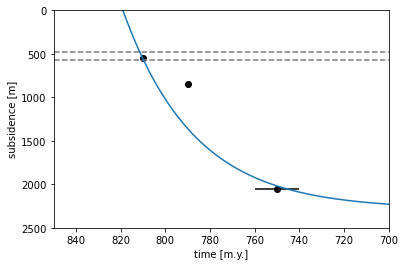

In [71]:
fig, ax = plt.subplots()

t_G1 = 810
t_G1_uncertainty = 1
t_S1 = 790
t_S1_uncertainty = 1
t_top = 750
t_top_uncertainty = 10

h_G1 = 550
h_G1_uncertainty = 50
h_S1 = 850
h_S1_uncertainty = 50
h_top = 2050
h_top_uncertainty = 50

ax.scatter(t_G1, h_G1, c='k')
ax.scatter(t_S1, h_S1, c='k')
ax.scatter(t_top, h_top, c='k')
ax.errorbar(t_top, h_top, xerr=t_top_uncertainty, c='k')

ax.axhline(h_G1-70, c='C7',ls='--')
ax.axhline(h_G1+25, c='C7',ls='--')

t_start = 819
t_Ma = -(t/my_s)+t_start
ax.plot(t_Ma, S)

ax.set_xlim(850,700)
ax.set_ylim(2500,0)

ax.set_xlabel('time [m.y.]')
ax.set_ylabel('subsidence [m]')

plt.show(fig)

In [72]:
LG_age_lower = np.interp(h_G1-70, S, t_Ma)
UG_age_upper = np.interp(h_G1+25, S, t_Ma)

print('LG_age_lower = {:.2f} Ma'.format(LG_age_lower))
print('UG_age_upper = {:.2f} Ma'.format(UG_age_upper))

LG_age_lower = 811.43 Ma
UG_age_upper = 809.69 Ma


In [73]:
np.random.seed(2020)

# Lower Grus.
pole1_plon = 204.9
pole1_plat = 19.6
pole1_kappa = 39.9
pole1_N = 4
pole1_age_lower = 815
pole1_age_upper = 810.5
pole1_MCages = np.random.uniform(pole1_age_upper, pole1_age_lower, samplesize)

# Upper Grus.
pole2_plon = 72.6+180
pole2_plat = -1.1
pole2_kappa = 84.2
pole2_N = 5
pole2_age_lower = 809.5
pole2_age_upper = 805
pole2_MCages = np.random.uniform(pole2_age_upper, pole2_age_lower, samplesize)

print('pole1_age_lower = {:.2f} Ma'.format(pole1_age_lower))
print('pole1_age_upper = {:.2f} Ma'.format(pole1_age_upper))
print('pole2_age_lower = {:.2f} Ma'.format(pole2_age_lower))
print('pole2_age_upper = {:.2f} Ma'.format(pole2_age_upper))

LG_UG = plate_rate_mc(pole1_plon,pole1_plat,pole1_kappa,pole1_N,pole1_age,pole1_MCages,
                      pole2_plon,pole2_plat,pole2_kappa,pole2_N,pole2_age,pole2_MCages,
                      18.5,79.0,
                      samplesize=samplesize, random_seed=2020)

pole1_age_lower = 815.00 Ma
pole1_age_upper = 810.50 Ma
pole2_age_lower = 809.50 Ma
pole2_age_upper = 805.00 Ma
angular difference between the means = 51.14
paleolatitude for ref_loc resulting from the mean of pole1 = 8.66
paleolatitude for ref_loc resulting from the mean of pole2 = -7.51
rate of paleolatitudinal change implied by the means = 19.77 cm/yr
plate velocity implied by the means = 62.49 cm/yr


Plots:

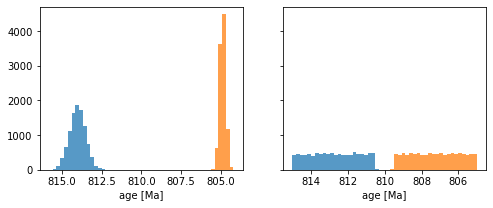

In [74]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,3), sharey=True)

bins = np.linspace(np.min([BX_MY['pole1_MC_ages'],BX_MY['pole2_MC_ages']]),
                   np.max([BX_MY['pole1_MC_ages'],BX_MY['pole2_MC_ages']]),
                   50)
ax[0].hist(BX_MY['pole1_MC_ages'], color='C0', alpha=0.75, bins=bins)
ax[0].hist(BX_MY['pole2_MC_ages'], color='C1', alpha=0.75, bins=bins)
ax[0].set_xlabel('age [Ma]')
ax[0].invert_xaxis()

bins = np.linspace(np.min([LG_UG['pole1_MC_ages'],LG_UG['pole2_MC_ages']]),
                   np.max([LG_UG['pole1_MC_ages'],LG_UG['pole2_MC_ages']]),
                   50)
ax[1].hist(LG_UG['pole1_MC_ages'], color='C0', alpha=0.75, bins=bins)
ax[1].hist(LG_UG['pole2_MC_ages'], color='C1', alpha=0.75, bins=bins)
ax[1].set_xlabel('age [Ma]')
ax[1].invert_xaxis()

plt.show(fig)

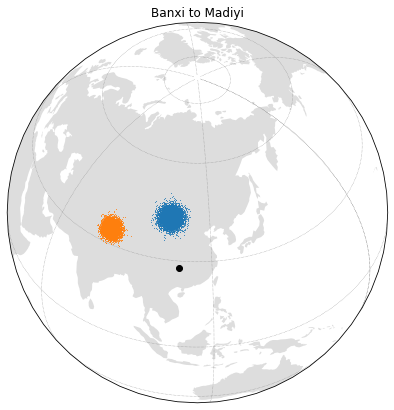

In [75]:
lat_grid = [-80,-60,-30,0,30,60,80]
lon_grid = np.arange(-180,180+60,60)

ax = ipmag.make_orthographic_map(add_land=False, central_longitude=115, central_latitude=45,
                                 figsize=(7,7), grid_lines=False)

ax.add_feature(cartopy.feature.LAND, zorder=-99,
               facecolor='#dddddd', edgecolor='none')

ipmag.plot_vgp(ax, BX_MY['pole1_MC_plon'], BX_MY['pole1_MC_plat'], color='C0', edge='none', markersize=1)
ipmag.plot_vgp(ax, BX_MY['pole2_MC_plon'], BX_MY['pole2_MC_plat'], color='C1', edge='none', markersize=1)

ax.scatter(108.82,27.91,transform=ccrs.PlateCarree(), c='k')

ax.gridlines(xlocs=lon_grid, ylocs=lat_grid, linewidth=0.5,
             color='C7', linestyle='dotted', zorder=-1)

ax.set_title('Banxi to Madiyi')

plt.savefig('../Output/TPW_MC_SChina.pdf', bbox_inches='tight')
plt.show(fig)

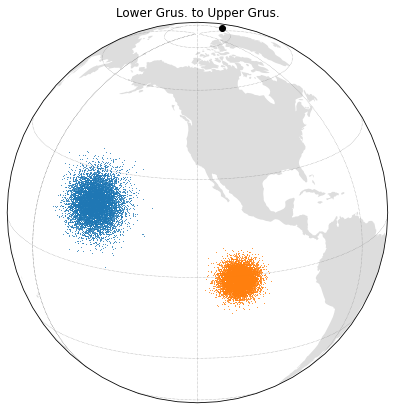

In [76]:
lat_grid = [-80,-60,-30,0,30,60,80]
lon_grid = np.arange(-180,180+60,60)

ax = ipmag.make_orthographic_map(add_land=False, central_longitude=240, central_latitude=20,
                                 figsize=(7,7), grid_lines=False)

ax.add_feature(cartopy.feature.LAND, zorder=-99,
               facecolor='#dddddd', edgecolor='none')

ipmag.plot_vgp(ax, LG_UG['pole1_MC_plon'], LG_UG['pole1_MC_plat'], color='C0', edge='none', markersize=1)
ipmag.plot_vgp(ax, LG_UG['pole2_MC_plon'], LG_UG['pole2_MC_plat'], color='C1', edge='none', markersize=1)

ax.scatter(18.5,79.0,transform=ccrs.PlateCarree(), c='k')

ax.gridlines(xlocs=lon_grid, ylocs=lat_grid, linewidth=0.5,
             color='C7', linestyle='dotted', zorder=-1)

ax.set_title('Lower Grus. to Upper Grus.')

plt.savefig('../Output/TPW_MC_Svalbard.pdf', bbox_inches='tight')
plt.show(fig)

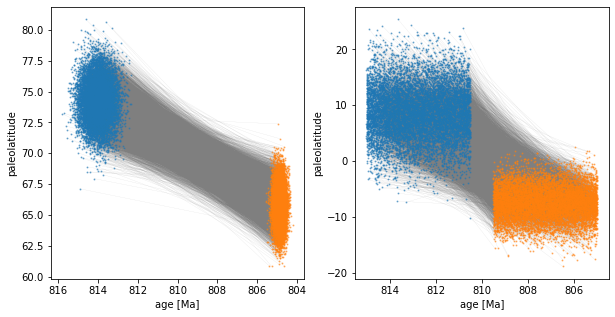

In [77]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

ax[0].scatter(BX_MY['pole1_MC_ages'], BX_MY['pole1_MC_paleolat'], s=1, c='C0', alpha=0.5)
ax[0].scatter(BX_MY['pole2_MC_ages'], BX_MY['pole2_MC_paleolat'], s=1, c='C1', alpha=0.5)
ax[0].plot([BX_MY['pole1_MC_ages'],BX_MY['pole2_MC_ages']],
           [BX_MY['pole1_MC_paleolat'],BX_MY['pole2_MC_paleolat']],
           c='C7', linewidth=0.1, zorder=-99, alpha=0.5)

ax[1].scatter(LG_UG['pole1_MC_ages'], LG_UG['pole1_MC_paleolat'], s=1, c='C0', alpha=0.5)
ax[1].scatter(LG_UG['pole2_MC_ages'], LG_UG['pole2_MC_paleolat'], s=1, c='C1', alpha=0.5)
ax[1].plot([LG_UG['pole1_MC_ages'],LG_UG['pole2_MC_ages']],
           [LG_UG['pole1_MC_paleolat'],LG_UG['pole2_MC_paleolat']],
           c='C7', linewidth=0.1, zorder=-99, alpha=0.5)

ax[0].set_xlabel('age [Ma]')
ax[1].set_xlabel('age [Ma]')
ax[0].set_ylabel('paleolatitude')
ax[1].set_ylabel('paleolatitude')
ax[0].invert_xaxis()
ax[1].invert_xaxis()

plt.show()

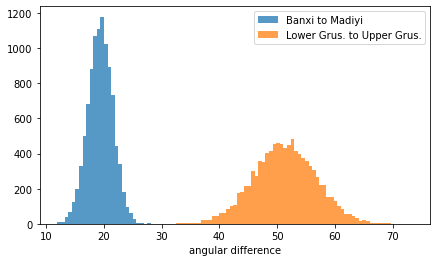

In [78]:
fig, ax = plt.subplots(figsize=(7,4))

bins = np.linspace(np.min([BX_MY['angular_degrees'],LG_UG['angular_degrees']]),
                   np.max([BX_MY['angular_degrees'],LG_UG['angular_degrees']]),
                   100)
ax.hist(BX_MY['angular_degrees'], color='C0', alpha=0.75, bins=bins, label='Banxi to Madiyi')
ax.hist(LG_UG['angular_degrees'], color='C1', alpha=0.75, bins=bins, label='Lower Grus. to Upper Grus.')

ax.legend()
ax.set_xlabel('angular difference')

plt.show(fig)

As per [math](https://math.stackexchange.com/questions/40224/probability-of-a-point-taken-from-a-certain-normal-distribution-will-be-greater):

In [80]:
LG_UG_angular_mean = np.mean(LG_UG['angular_degrees'])
LG_UG_angular_std = np.std(LG_UG['angular_degrees'])

BX_MY_angular_mean = np.mean(BX_MY['angular_degrees'])
BX_MY_angular_std = np.std(BX_MY['angular_degrees'])

p_angular_overlap = 1-(stats.norm.cdf(-(BX_MY_angular_mean-LG_UG_angular_mean)/\
                                      np.sqrt(BX_MY_angular_std**2 + LG_UG_angular_std**2)))

print('joint probability that BX_MY is greater than LG_UG = {:.1e}%'.format(p_angular_overlap*100))

joint probability that BX_MY is greater than LG_UG = 2.2e-06%


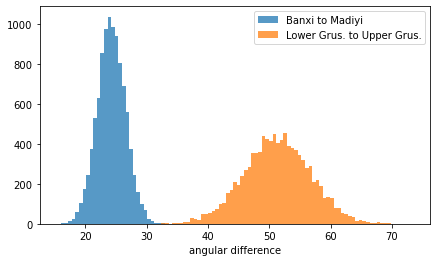

In [81]:
fig, ax = plt.subplots(figsize=(7,4))

bins = np.linspace(np.min([LM_MY['angular_degrees'],LG_UG['angular_degrees']]),
                   np.max([LM_MY['angular_degrees'],LG_UG['angular_degrees']]),
                   100)
ax.hist(LM_MY['angular_degrees'], color='C0', alpha=0.75, bins=bins, label='Banxi to Madiyi')
ax.hist(LG_UG['angular_degrees'], color='C1', alpha=0.75, bins=bins, label='Lower Grus. to Upper Grus.')

ax.legend()
ax.set_xlabel('angular difference')

plt.show(fig)

In [82]:
LG_UG_angular_mean = np.mean(LG_UG['angular_degrees'])
LG_UG_angular_std = np.std(LG_UG['angular_degrees'])

LM_MY_angular_mean = np.mean(LM_MY['angular_degrees'])
LM_MY_angular_std = np.std(LM_MY['angular_degrees'])

p_angular_overlap = 1-(stats.norm.cdf(-(LM_MY_angular_mean-LG_UG_angular_mean)/\
                                      np.sqrt(LM_MY_angular_std**2 + LG_UG_angular_std**2)))

print('joint probability that LM_MY is greater than LG_UG = {:.1e}%'.format(p_angular_overlap*100))

joint probability that LM_MY is greater than LG_UG = 2.1e-04%


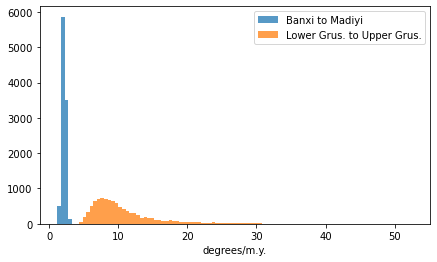

In [83]:
fig, ax = plt.subplots(figsize=(7,4))

bins = np.linspace(np.min([BX_MY['angular_degrees_per_myr'],LG_UG['angular_degrees_per_myr']]),
                   np.min([np.max([BX_MY['angular_degrees_per_myr'],LG_UG['angular_degrees_per_myr']]),500]),
                   100)
ax.hist(BX_MY['angular_degrees_per_myr'], color='C0', alpha=0.75, bins=bins, label='Banxi to Madiyi')
ax.hist(LG_UG['angular_degrees_per_myr'], color='C1', alpha=0.75, bins=bins, label='Lower Grus. to Upper Grus.')

ax.legend()
ax.set_xlabel('degrees/m.y.')

plt.show(fig)

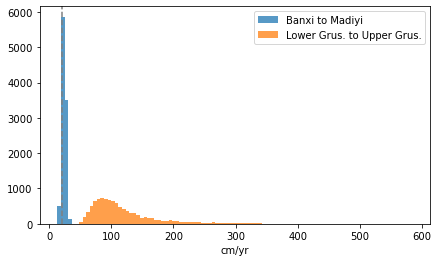

In [84]:
fig, ax = plt.subplots(figsize=(7,4))

bins = np.linspace(np.min([BX_MY['angular_cm_per_yr'],LG_UG['angular_cm_per_yr']]),
                   np.min([np.max([BX_MY['angular_cm_per_yr'],LG_UG['angular_cm_per_yr']]),1000]),
                   100)
ax.hist(BX_MY['angular_cm_per_yr'], color='C0', alpha=0.75, bins=bins, label='Banxi to Madiyi')
ax.hist(LG_UG['angular_cm_per_yr'], color='C1', alpha=0.75, bins=bins, label='Lower Grus. to Upper Grus.')

ax.axvline(20, c='C7', ls='--')

ax.legend()
ax.set_xlabel('cm/yr')

plt.show(fig)

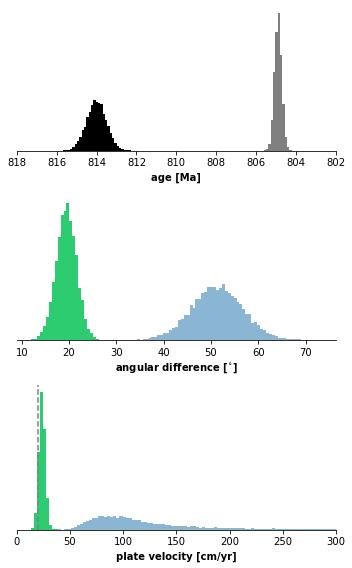

In [85]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(5,8))

bins = np.linspace(np.min([BX_MY['pole1_MC_ages'],BX_MY['pole2_MC_ages']]),
                   np.max([BX_MY['pole1_MC_ages'],BX_MY['pole2_MC_ages']]),
                   100)
ax[0].hist(BX_MY['pole1_MC_ages'], color='k', alpha=1.0, bins=bins, label='Banxi')
ax[0].hist(BX_MY['pole2_MC_ages'], color='grey', alpha=1.0, bins=bins, label='Madiyi')
ax[0].set_xlabel('age [Ma]', fontweight='bold')
ax[0].set_xticks(np.arange(802,818+2,2))
ax[0].set_xlim(818,802)
#ax[0].legend()

bins = np.linspace(np.min([BX_MY['angular_degrees'],LG_UG['angular_degrees']]),
                   np.max([BX_MY['angular_degrees'],LG_UG['angular_degrees']]),
                   100)
ax[1].hist(BX_MY['angular_degrees'], color=SChina_color, alpha=1.0, bins=bins, label='Banxi to Madiyi')
ax[1].hist(LG_UG['angular_degrees'], color=Svalbard_color, alpha=1.0, bins=bins, label='Lower Grus. to Upper Grus.')
#ax[1].legend()
ax[1].set_xlabel('angular difference [$^{\circ}$]', fontweight='bold')

bins = np.linspace(np.min([BX_MY['angular_cm_per_yr'],LG_UG['angular_cm_per_yr']]),
                   np.max([BX_MY['angular_cm_per_yr'],LG_UG['angular_cm_per_yr']]),
                   200)
ax[2].hist(BX_MY['angular_cm_per_yr'], color=SChina_color, alpha=1.0, bins=bins, label='Banxi to Madiyi')
ax[2].hist(LG_UG['angular_cm_per_yr'], color=Svalbard_color, alpha=1.0, bins=bins, label='Lower Grus. to Upper Grus.')
ax[2].axvline(20, c='C7', ls='--')
ax[2].set_xlim(0,300)
#ax[2].legend()
ax[2].set_xlabel('plate velocity [cm/yr]', fontweight='bold')

for i in range(3):
    ax[i].set_yticks([])
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['left'].set_visible(False)
    ax[i].spines['top'].set_visible(False)

fig.tight_layout()
plt.savefig('../Output/TPW_MC.pdf', bbox_inches='tight')
plt.show(fig)

## Other Poles

In [ ]:
pole_path = '../../../Rodinia_Model/Torsvik-extended/poles/raw-data/'

### Laurentia

#### Compilation

In [ ]:
Laurentia = pd.DataFrame(columns=compilation_cols)

In [ ]:
SwansonHysell_preprint = pd.read_csv(pole_path+'Swanson-Hysell_preprint.csv')
SwansonHysell_preprint.columns

Clean up the age column:

In [ ]:
SwansonHysell_preprint_age_nominal = []
SwansonHysell_preprint_age_upper = []
SwansonHysell_preprint_age_lower = []

for age in SwansonHysell_preprint['age']:
    age_split = age.split('$')
    age_nominal = np.float(age_split[0])
    age_split_upper_lower = age_split[1].split('}')
    age_split_upper = age_split_upper_lower[0].split('+')[1]
    age_split_lower = age_split_upper_lower[1].split('-')[1]
    age_upper = np.float(age_split_upper)
    age_lower = np.float(age_split_lower)
    
    SwansonHysell_preprint_age_nominal.append(age_nominal)
    SwansonHysell_preprint_age_upper.append(age_nominal + age_upper)
    SwansonHysell_preprint_age_lower.append(age_nominal - age_lower)

Assign columns:

In [ ]:
Laurentia['name'] = SwansonHysell_preprint['unit name']
Laurentia['terrane'] = SwansonHysell_preprint['terrane']
Laurentia['age'] = SwansonHysell_preprint_age_nominal
Laurentia['age upper'] = SwansonHysell_preprint_age_upper
Laurentia['age lower'] = SwansonHysell_preprint_age_lower
Laurentia['plat'] = SwansonHysell_preprint['plat']
Laurentia['plon'] = SwansonHysell_preprint['plon']
Laurentia['a95'] = SwansonHysell_preprint['a95']
#Laurentia['f']
Laurentia['slat'] = SwansonHysell_preprint['slat']
Laurentia['slon'] = SwansonHysell_preprint['slon']
#Laurentia['dec']
#Laurentia['inc']
#Laurentia['dir_a95']
Laurentia['pole ref'] = SwansonHysell_preprint['pole reference']
#Laurentia['age ref']
Laurentia['grade'] = SwansonHysell_preprint['Nordic rating']
#Laurentia['note']
#Laurentia['plateID']

Add Adirondack poles:

In [ ]:
i = len(Laurentia)

Laurentia.loc[i, 'name']    = 'Adirondack fayalite granite'
Laurentia.loc[i, 'terrane'] = 'Laurentia'
Laurentia.loc[i, 'age']       = 990
Laurentia.loc[i, 'age upper'] = 990 + 20
Laurentia.loc[i, 'age lower'] = 990 - 20
Laurentia.loc[i, 'plat'] = -28.4
Laurentia.loc[i, 'plon'] = 132.7
Laurentia.loc[i, 'a95']  = 6.9
Laurentia.loc[i, 'f'] = np.nan
Laurentia.loc[i, 'slat'] = 44.0
Laurentia.loc[i, 'slon'] = 285.5
Laurentia.loc[i, 'dec']     = np.nan
Laurentia.loc[i, 'inc']     = np.nan
Laurentia.loc[i, 'dir_a95'] = np.nan
Laurentia.loc[i, 'pole ref'] = 'Brown et al. (2012)'
Laurentia.loc[i, 'age ref']  = '-'
Laurentia.loc[i, 'grade'] = 'NR'
Laurentia.loc[i, 'note']  = '-'
Laurentia.loc[i, 'plateID'] = 101
i = i + 1

Laurentia.loc[i, 'name']    = 'Adirondack metamorphic anorthosites'
Laurentia.loc[i, 'terrane'] = 'Laurentia'
Laurentia.loc[i, 'age']       = 970
Laurentia.loc[i, 'age upper'] = 970 + 20
Laurentia.loc[i, 'age lower'] = 970 - 20
Laurentia.loc[i, 'plat'] = -25.1
Laurentia.loc[i, 'plon'] = 149.0
Laurentia.loc[i, 'a95']  = 11.6
Laurentia.loc[i, 'f'] = np.nan
Laurentia.loc[i, 'slat'] = 44.0
Laurentia.loc[i, 'slon'] = 286.0
Laurentia.loc[i, 'dec']     = np.nan
Laurentia.loc[i, 'inc']     = np.nan
Laurentia.loc[i, 'dir_a95'] = np.nan
Laurentia.loc[i, 'pole ref'] = 'Brown et al. (2012)'
Laurentia.loc[i, 'age ref']  = '-'
Laurentia.loc[i, 'grade'] = 'NR'
Laurentia.loc[i, 'note']  = '-'
Laurentia.loc[i, 'plateID'] = 101
i = i + 1

Laurentia.loc[i, 'name']    = 'Adirondack Microcline gneiss'
Laurentia.loc[i, 'terrane'] = 'Laurentia'
Laurentia.loc[i, 'age']       = 960
Laurentia.loc[i, 'age upper'] = 960 + 20
Laurentia.loc[i, 'age lower'] = 960 - 20
Laurentia.loc[i, 'plat'] = -18.4
Laurentia.loc[i, 'plon'] = 151.1
Laurentia.loc[i, 'a95']  = 10.5
Laurentia.loc[i, 'f'] = np.nan
Laurentia.loc[i, 'slat'] = 44.0
Laurentia.loc[i, 'slon'] = 285.0
Laurentia.loc[i, 'dec']     = np.nan
Laurentia.loc[i, 'inc']     = np.nan
Laurentia.loc[i, 'dir_a95'] = np.nan
Laurentia.loc[i, 'pole ref'] = 'Brown et al. (2012)'
Laurentia.loc[i, 'age ref']  = '-'
Laurentia.loc[i, 'grade'] = 'NR'
Laurentia.loc[i, 'note']  = '-'
Laurentia.loc[i, 'plateID'] = 101
i = i + 1

Assign plateIDs:

In [ ]:
# 101 for most poles
Laurentia['plateID'] = 101

# other poles
Laurentia.loc[Laurentia['name']=='Torridon Group','plateID'] = 303
Laurentia.loc[Laurentia['name']=='Lower Grusdievbreen Formation','plateID'] = 311
Laurentia.loc[Laurentia['name']=='Upper Grusdievbreen Formation','plateID'] = 311
Laurentia.loc[Laurentia['name']=='Svanbergfjellet Formation','plateID'] = 311

Flip polarity of some poles:

In [ ]:
flip_poles = ['Long Range Dykes','Baie des Moutons complex','Callander Alkaline Complex','Catoctin Basalts','Sept-Iles layered intrusion']
for i in Laurentia.index:
    if Laurentia['name'][i] in flip_poles:
        Laurentia.loc[i,'dec'] = (Laurentia['dec'][i] + 180) % 360
        Laurentia.loc[i,'inc'] = -Laurentia['inc'][i]
        Laurentia.loc[i,'plat'] = -Laurentia['plat'][i]
        Laurentia.loc[i,'plon'] = (Laurentia['plon'][i] + 180) % 360

#### Summary

In [ ]:
Laurentia.sort_values('age', ascending=False, inplace=True)
Laurentia = Laurentia[compilation_cols]
Laurentia.reset_index(inplace=True, drop=True)
Laurentia

In [ ]:
Laurentia.to_csv('../Output/Laurentia-poles.csv',index=False)
Laurentia_vpgFeatureCollection = create_vgp_FeatureCollection(Laurentia)
create_vgp_gpml(Laurentia_vpgFeatureCollection, '../Output/Laurentia-poles.gpml')

### India

#### Compilation

In [ ]:
India = pd.DataFrame(columns=compilation_cols)

In [ ]:
Leirubakki_India = pd.read_csv(pole_path+'Leirubakki-India.csv')
Leirubakki_India.columns

Clean up the pole references column:

In [ ]:
Leirubakki_India_pole_ref = []

for i in range(len(Leirubakki_India)):
    pole_ref = str(Leirubakki_India['POLE AUTHORS'][i]) + ' (' + str(Leirubakki_India['YEAR'][i]) + ')'
    Leirubakki_India_pole_ref.append(pole_ref)

Assign columns:

In [ ]:
India['name'] = Leirubakki_India['POLENAME']
India['terrane'] = Leirubakki_India['Terrane']
India['age'] = Leirubakki_India['nominal age']
India['age upper'] = Leirubakki_India['himagage']
India['age lower'] = Leirubakki_India['lomagage']
India['plat'] = Leirubakki_India['PLAT']
India['plon'] = Leirubakki_India['PLON']
India['a95'] = Leirubakki_India['A95']
#India['f']
India['slat'] = Leirubakki_India['SLAT']
India['slon'] = Leirubakki_India['SLON']
India['dec'] = Leirubakki_India['DEC']
India['inc'] = Leirubakki_India['INC']
#India['dir_a95']
India['pole ref'] = Leirubakki_India_pole_ref
#India['age ref']
India['grade'] = Leirubakki_India['Grade']
#India['note']
India['plateID'] = 501

Update age of the Malani Igneous Suite:

In [ ]:
India.loc[India['name']=='Malani Igneous Suite -Comb','age'] = 752
India.loc[India['name']=='Malani Igneous Suite -Comb','age upper'] = 752 + 18
India.loc[India['name']=='Malani Igneous Suite -Comb','age lower'] = 752 - 18

#### Summary

In [ ]:
India.sort_values('age', ascending=False, inplace=True)
India = India[compilation_cols]
India.reset_index(inplace=True, drop=True)
India

In [ ]:
India.to_csv('../Output/India-poles.csv',index=False)
India_vpgFeatureCollection = create_vgp_FeatureCollection(India)
create_vgp_gpml(India_vpgFeatureCollection, '../Output/India-poles.gpml')

### Australia

#### Compilation

In [ ]:
Australia = pd.DataFrame(columns=compilation_cols)

In [ ]:
Leirubakki_Australia = pd.read_csv(pole_path+'Leirubakki-Australia.csv')
Leirubakki_Australia.columns

Clean up the pole references column:

In [ ]:
Leirubakki_Australia_pole_ref = []

for i in range(len(Leirubakki_Australia)):
    pole_ref = str(Leirubakki_Australia['POLE AUTHORS'][i]) + ' (' + str(Leirubakki_Australia['YEAR'][i]) + ')'
    Leirubakki_Australia_pole_ref.append(pole_ref)

Assign columns:

In [ ]:
Australia['name'] = Leirubakki_Australia['POLENAME']
Australia['terrane'] = Leirubakki_Australia['Terrane']
Australia['age'] = Leirubakki_Australia['nominal age']
Australia['age upper'] = Leirubakki_Australia['himagage']
Australia['age lower'] = Leirubakki_Australia['lomagage']
Australia['plat'] = Leirubakki_Australia['PLAT']
Australia['plon'] = Leirubakki_Australia['PLON']
Australia['a95'] = Leirubakki_Australia['A95']
#Australia['f']
Australia['slat'] = Leirubakki_Australia['SLAT']
Australia['slon'] = Leirubakki_Australia['SLON']
Australia['dec'] = Leirubakki_Australia['DEC']
Australia['inc'] = Leirubakki_Australia['INC']
#Australia['dir_a95']
Australia['pole ref'] = Leirubakki_Australia_pole_ref
#Australia['age ref']
Australia['grade'] = Leirubakki_Australia['Grade']
#Australia['note']
#Australia['plateID']

Assign plateIDs:

In [ ]:
# 801 for most poles
Australia['plateID'] = 801

# other poles
Australia.loc[Australia['name']=='Cap Dolomite, Walsh Tillite','plateID'] = 8011
Australia.loc[Australia['name']=='Lower Arumbera and Upper Pertatataka Formations','plateID'] = 8011
Australia.loc[Australia['name']=="Johnny's Creek siltstones",'plateID'] = 8011
Australia.loc[Australia['name']=='Mt.Isa Dolerite Dykes (IAR)','plateID'] = 8011
Australia.loc[Australia['name']=='Alcurra dykes+sills','plateID'] = 8011

#### Summary

In [ ]:
Australia.sort_values('age', ascending=False, inplace=True)
Australia = Australia[compilation_cols]
Australia.reset_index(inplace=True, drop=True)
Australia

In [ ]:
Australia.to_csv('../Output/Australia-poles.csv',index=False)
Australia_vpgFeatureCollection = create_vgp_FeatureCollection(Australia)
create_vgp_gpml(Australia_vpgFeatureCollection, '../Output/Australia-poles.gpml')

### Siberia

#### Compilation

In [ ]:
Siberia = pd.DataFrame(columns=compilation_cols)

In [ ]:
Leirubakki_Siberia = pd.read_csv(pole_path+'Leirubakki-Siberia.csv')
Leirubakki_Siberia.columns

Clean up the pole references column:

In [ ]:
Leirubakki_Siberia_pole_ref = []

for i in range(len(Leirubakki_Siberia)):
    pole_ref = str(Leirubakki_Siberia['POLE AUTHORS'][i]) + ' (' + str(Leirubakki_Siberia['YEAR'][i]) + ')'
    Leirubakki_Siberia_pole_ref.append(pole_ref)

Assign columns:

In [ ]:
Siberia['name'] = Leirubakki_Siberia['POLENAME']
Siberia['terrane'] = Leirubakki_Siberia['Terrane']
Siberia['age'] = Leirubakki_Siberia['nominal age']
Siberia['age upper'] = Leirubakki_Siberia['himagage']
Siberia['age lower'] = Leirubakki_Siberia['lomagage']
Siberia['plat'] = Leirubakki_Siberia['PLAT']
Siberia['plon'] = Leirubakki_Siberia['PLON']
Siberia['a95'] = Leirubakki_Siberia['A95']
#Siberia['f']
Siberia['slat'] = Leirubakki_Siberia['SLAT']
Siberia['slon'] = Leirubakki_Siberia['SLON']
Siberia['dec'] = Leirubakki_Siberia['DEC']
Siberia['inc'] = Leirubakki_Siberia['INC']
#Siberia['dir_a95']
Siberia['pole ref'] = Leirubakki_Siberia_pole_ref
#Siberia['age ref']
Siberia['grade'] = Leirubakki_Siberia['Grade']
#Siberia['note']
#Siberia['plateID'] = 401

Assign plateIDs:

In [ ]:
# 403 for most poles
Siberia['plateID'] = 403

# other poles
Siberia.loc[Siberia['name']=='Linok Formation','plateID'] = 401
Siberia.loc[Siberia['name']=='Kartochka Formation','plateID'] = 401
Siberia.loc[Siberia['name']=='Kitoi Cryogenian dykes','plateID'] = 401

#### Summary

In [ ]:
Siberia.sort_values('age', ascending=False, inplace=True)
Siberia = Siberia[compilation_cols]
Siberia.reset_index(inplace=True, drop=True)
Siberia

In [ ]:
Siberia.to_csv('../Output/Siberia-poles.csv',index=False)
Siberia_vpgFeatureCollection = create_vgp_FeatureCollection(Siberia)
create_vgp_gpml(Siberia_vpgFeatureCollection, '../Output/Siberia-poles.gpml')